In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from tqdm import tqdm

2025-09-08 15:25:39.085839: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# PHIÊN BẢN CẢI THIỆN - Pipeline xử lý dữ liệu phù hợp với đặc điểm dataset

# Đường dẫn thư mục
DATA_DIR = Path("data/splits")
PROCESSED_DIR = Path("data/processed")
AUGMENTED_DIR = Path("data/augmented")

CLASSES_CORRECTED = ["brown_spot", "blast", "bacterial_leaf_blight", "normal"]
SPLITS = ["train", "val", "test"]

TARGET_SIZE = (224, 224)

MIN_BRIGHTNESS_THRESHOLD = 120  # Ngưỡng độ sáng thấp
SMALL_IMAGE_THRESHOLD = 100     # Ngưỡng ảnh nhỏ


In [3]:
def create_directories_corrected():
    """Tạo thư mục với tên lớp chính xác"""
    for dir_path in [PROCESSED_DIR, AUGMENTED_DIR]:
        for split in SPLITS:
            for cls in CLASSES_CORRECTED:
                path = dir_path / split / cls
                path.mkdir(parents=True, exist_ok=True)
                print(f"Đã tạo thư mục: {path}")

def smart_resize(img, target_size):
    """Resize thông minh dựa trên kích thước ảnh gốc"""
    h, w = img.shape[:2]
    
    if h < SMALL_IMAGE_THRESHOLD or w < SMALL_IMAGE_THRESHOLD:
        # Ảnh rất nhỏ (64x64) - phóng to trước rồi resize
        scale_factor = max(target_size[0]/h, target_size[1]/w) * 1.2  # Phóng to thêm 20%
        new_h, new_w = int(h * scale_factor), int(w * scale_factor)
        img_temp = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
        # Sau đó resize về đúng kích thước với INTER_AREA để giảm aliasing
        img_resized = cv2.resize(img_temp, target_size, interpolation=cv2.INTER_AREA)
        print(f"Xử lý ảnh nhỏ: {w}x{h} -> {new_w}x{new_h} -> {target_size[0]}x{target_size[1]}")
        
    elif h < target_size[0] or w < target_size[1]:
        # Ảnh nhỏ hơn target - dùng INTER_CUBIC
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_CUBIC)
        print(f"Phóng to ảnh: {w}x{h} -> {target_size[0]}x{target_size[1]}")
        
    else:
        # Ảnh lớn hơn target - dùng INTER_AREA
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        print(f"Thu nhỏ ảnh: {w}x{h} -> {target_size[0]}x{target_size[1]}")
    
    return img_resized


In [4]:
def preprocess_images_improved():
    """Pipeline xử lý ảnh cải thiện phù hợp với đặc điểm dataset"""
    total_processed = 0
    stats = {
        'small_images': 0,
        'dark_images': 0,
        'bright_images': 0,
        'normal_images': 0
    }
    
    for split in SPLITS:
        for cls in CLASSES_CORRECTED:
            src_dir = DATA_DIR / split / cls
            dst_dir = PROCESSED_DIR / split / cls
            
            if not src_dir.exists():
                print(f"Thư mục không tồn tại: {src_dir}")
                continue
                
            files = list(src_dir.glob("*"))
            print(f"\nĐang xử lý {len(files)} ảnh từ {split}/{cls}...")
            
            for img_path in tqdm(files, desc=f"{split}/{cls}"):
                try:
                    # Đọc ảnh
                    img = cv2.imread(str(img_path))
                    if img is None:
                        print(f"Không thể đọc ảnh: {img_path}")
                        continue
                    
                    # Thống kê kích thước ảnh
                    h, w = img.shape[:2]
                    if h < SMALL_IMAGE_THRESHOLD or w < SMALL_IMAGE_THRESHOLD:
                        stats['small_images'] += 1
                    
                    # Resize thông minh
                    img_resized = smart_resize(img, TARGET_SIZE)
                    
                    # Không chỉnh độ sáng nữa, chỉ thống kê
                    lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
                    l, a, b = cv2.split(lab)
                    l_mean = np.mean(l)

                    if l_mean < MIN_BRIGHTNESS_THRESHOLD:
                        stats['dark_images'] += 1
                    elif l_mean > 200:
                        stats['bright_images'] += 1
                    else:
                        stats['normal_images'] += 1

                    # Ghép lại các kênh (giữ nguyên L)
                    lab = cv2.merge((l, a, b))
                    img_enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
                    
                    # Áp dụng CLAHE cho tương phản - VỪA PHẢI
                    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))  # Giảm từ 2.0 -> 1.5
                    lab_final = cv2.cvtColor(img_enhanced, cv2.COLOR_BGR2LAB)
                    l_final, a_final, b_final = cv2.split(lab_final)
                    l_final = clahe.apply(l_final)
                    lab_final = cv2.merge((l_final, a_final, b_final))
                    img_enhanced = cv2.cvtColor(lab_final, cv2.COLOR_LAB2BGR)
                    
                    # Giảm nhiễu (chỉ cho ảnh nhỏ)
                    if h < SMALL_IMAGE_THRESHOLD or w < SMALL_IMAGE_THRESHOLD:
                        img_enhanced = cv2.fastNlMeansDenoisingColored(img_enhanced, None, 5, 5, 7, 21)
                    
                    # Tăng độ sắc nét NHẸ - VỪA PHẢI
                    kernel = np.array([[0, -0.3, 0], [-0.3, 2.2, -0.3], [0, -0.3, 0]])  # Giảm độ mạnh
                    img_enhanced = cv2.addWeighted(img_enhanced, 0.8, cv2.filter2D(img_enhanced, -1, kernel), 0.2, 0)
                    
                    # Lưu ảnh đã xử lý
                    output_path = dst_dir / img_path.name
                    cv2.imwrite(str(output_path), img_enhanced)
                    total_processed += 1
                    
                except Exception as e:
                    print(f"Lỗi khi xử lý {img_path}: {e}")
    
    print(f"\n=== THỐNG KÊ XỬ LÝ ===")
    print(f"Tổng số ảnh đã xử lý: {total_processed}")
    print(f"Ảnh nhỏ (< {SMALL_IMAGE_THRESHOLD}px): {stats['small_images']}")
    print(f"Ảnh tối (< {MIN_BRIGHTNESS_THRESHOLD}): {stats['dark_images']}")
    print(f"Ảnh sáng (> 200): {stats['bright_images']}")
    print(f"Ảnh bình thường: {stats['normal_images']}")

In [5]:
print("=== CHẠY PIPELINE XỬ LÝ DỮ LIỆU CẢI THIỆN ===")

print("\n1. Tạo thư mục...")
create_directories_corrected()

print("\n2. Xử lý ảnh...")
stats = preprocess_images_improved()


=== CHẠY PIPELINE XỬ LÝ DỮ LIỆU CẢI THIỆN ===

1. Tạo thư mục...
Đã tạo thư mục: data/processed/train/brown_spot
Đã tạo thư mục: data/processed/train/blast
Đã tạo thư mục: data/processed/train/bacterial_leaf_blight
Đã tạo thư mục: data/processed/train/normal
Đã tạo thư mục: data/processed/val/brown_spot
Đã tạo thư mục: data/processed/val/blast
Đã tạo thư mục: data/processed/val/bacterial_leaf_blight
Đã tạo thư mục: data/processed/val/normal
Đã tạo thư mục: data/processed/test/brown_spot
Đã tạo thư mục: data/processed/test/blast
Đã tạo thư mục: data/processed/test/bacterial_leaf_blight
Đã tạo thư mục: data/processed/test/normal
Đã tạo thư mục: data/augmented/train/brown_spot
Đã tạo thư mục: data/augmented/train/blast
Đã tạo thư mục: data/augmented/train/bacterial_leaf_blight
Đã tạo thư mục: data/augmented/train/normal
Đã tạo thư mục: data/augmented/val/brown_spot
Đã tạo thư mục: data/augmented/val/blast
Đã tạo thư mục: data/augmented/val/bacterial_leaf_blight
Đã tạo thư mục: data/augmen

train/brown_spot:   0%|          | 0/2116 [00:00<?, ?it/s]

train/brown_spot:   0%|          | 2/2116 [00:00<03:00, 11.71it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:   0%|          | 7/2116 [00:00<01:17, 27.14it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:   1%|          | 18/2116 [00:00<01:00, 34.66it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:   1%|          | 22/2116 [00:00<00:59, 35.32it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:   1%|▏         | 29/2116 [00:01<01:20, 25.90it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:   2%|▏         | 38/2116 [00:01<01:06, 31.04it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:   2%|▏         | 51/2116 [00:01<00:53, 38.85it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:   3%|▎         | 63/2116 [00:01<00:43, 47.41it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:   3%|▎         | 68/2116 [00:01<00:53, 38.03it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:   5%|▍         | 99/2116 [00:02<00:29, 68.41it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:   5%|▌         | 106/2116 [00:02<00:43, 46.65it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:   5%|▌         | 112/2116 [00:02<00:42, 46.74it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:   6%|▌         | 118/2116 [00:02<00:54, 36.85it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:   6%|▌         | 123/2116 [00:03<00:53, 37.06it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:   6%|▌         | 132/2116 [00:03<00:59, 33.46it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:   6%|▋         | 136/2116 [00:03<01:07, 29.45it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:   7%|▋         | 140/2116 [00:03<01:06, 29.89it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:   7%|▋         | 150/2116 [00:04<01:06, 29.78it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:   7%|▋         | 158/2116 [00:04<00:54, 35.61it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:   8%|▊         | 166/2116 [00:04<01:07, 28.84it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:   8%|▊         | 175/2116 [00:04<00:54, 35.34it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:   9%|▊         | 184/2116 [00:05<00:59, 32.30it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:   9%|▉         | 192/2116 [00:05<01:07, 28.33it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:   9%|▉         | 199/2116 [00:05<00:53, 35.53it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  10%|▉         | 207/2116 [00:05<01:02, 30.74it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  10%|█         | 216/2116 [00:06<00:54, 34.69it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  11%|█         | 229/2116 [00:06<00:38, 48.39it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  11%|█▏        | 239/2116 [00:06<00:48, 38.35it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  11%|█▏        | 243/2116 [00:06<00:57, 32.44it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  12%|█▏        | 251/2116 [00:07<00:56, 33.20it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  12%|█▏        | 264/2116 [00:07<00:39, 47.33it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  13%|█▎        | 275/2116 [00:07<00:42, 43.32it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  13%|█▎        | 282/2116 [00:07<00:43, 41.99it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  14%|█▍        | 291/2116 [00:08<00:52, 34.76it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  14%|█▍        | 301/2116 [00:08<00:57, 31.57it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  15%|█▍        | 309/2116 [00:08<00:56, 31.89it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  15%|█▌        | 320/2116 [00:08<00:48, 37.31it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  16%|█▌        | 330/2116 [00:09<00:39, 45.07it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  16%|█▌        | 340/2116 [00:09<00:39, 45.27it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  17%|█▋        | 357/2116 [00:09<00:37, 47.12it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  17%|█▋        | 362/2116 [00:09<00:38, 45.06it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  18%|█▊        | 373/2116 [00:10<00:40, 43.35it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  18%|█▊        | 384/2116 [00:10<00:41, 41.90it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  19%|█▊        | 392/2116 [00:10<00:38, 45.03it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  19%|█▉        | 397/2116 [00:10<00:51, 33.29it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  19%|█▉        | 402/2116 [00:10<00:49, 34.98it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  20%|█▉        | 414/2116 [00:11<00:42, 40.10it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  20%|██        | 424/2116 [00:11<00:31, 53.60it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  21%|██        | 438/2116 [00:11<00:34, 49.32it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  21%|██        | 444/2116 [00:11<00:45, 36.71it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  21%|██▏       | 453/2116 [00:11<00:35, 46.64it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  22%|██▏       | 459/2116 [00:12<00:48, 34.06it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  22%|██▏       | 464/2116 [00:12<00:52, 31.37it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  22%|██▏       | 473/2116 [00:12<00:54, 30.06it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  23%|██▎       | 482/2116 [00:13<00:48, 33.74it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  23%|██▎       | 490/2116 [00:13<00:40, 40.41it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  24%|██▎       | 499/2116 [00:13<00:48, 33.58it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  24%|██▍       | 507/2116 [00:13<00:53, 29.80it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  24%|██▍       | 511/2116 [00:13<01:00, 26.72it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  24%|██▍       | 518/2116 [00:14<00:56, 28.29it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  25%|██▍       | 527/2116 [00:14<00:50, 31.55it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  25%|██▌       | 531/2116 [00:14<00:51, 31.05it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  26%|██▌       | 547/2116 [00:14<00:30, 51.62it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  26%|██▋       | 559/2116 [00:15<00:42, 36.32it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  27%|██▋       | 568/2116 [00:15<00:37, 41.77it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  27%|██▋       | 581/2116 [00:15<00:34, 44.14it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  28%|██▊       | 586/2116 [00:15<00:40, 37.61it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  28%|██▊       | 591/2116 [00:16<00:41, 36.42it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  28%|██▊       | 601/2116 [00:16<00:43, 34.89it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  29%|██▉       | 611/2116 [00:16<00:47, 31.44it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  29%|██▉       | 617/2116 [00:16<00:42, 34.94it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  29%|██▉       | 624/2116 [00:17<00:40, 37.06it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  30%|██▉       | 632/2116 [00:17<00:42, 35.03it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  30%|███       | 640/2116 [00:17<00:46, 32.01it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  31%|███       | 649/2116 [00:17<00:42, 34.53it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  31%|███       | 653/2116 [00:18<00:58, 25.12it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  32%|███▏      | 668/2116 [00:18<00:35, 41.36it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  32%|███▏      | 683/2116 [00:18<00:25, 56.81it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  33%|███▎      | 697/2116 [00:18<00:28, 50.07it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  33%|███▎      | 703/2116 [00:18<00:28, 50.45it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  34%|███▎      | 714/2116 [00:19<00:39, 35.68it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/brown_spot:  34%|███▍      | 718/2116 [00:19<00:40, 34.15it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  35%|███▍      | 732/2116 [00:19<00:33, 41.27it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  35%|███▌      | 743/2116 [00:19<00:34, 40.25it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  36%|███▌      | 752/2116 [00:20<00:37, 36.15it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  36%|███▌      | 756/2116 [00:20<00:45, 29.71it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  36%|███▌      | 765/2116 [00:20<00:45, 29.46it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  36%|███▋      | 771/2116 [00:20<00:37, 35.98it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  37%|███▋      | 781/2116 [00:21<00:36, 36.90it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  38%|███▊      | 795/2116 [00:21<00:30, 43.17it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  38%|███▊      | 801/2116 [00:21<00:30, 43.31it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  38%|███▊      | 810/2116 [00:21<00:42, 30.77it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/brown_spot:  39%|███▊      | 815/2116 [00:22<00:39, 32.72it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  39%|███▉      | 827/2116 [00:22<00:36, 35.05it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  40%|███▉      | 837/2116 [00:22<00:40, 31.28it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/brown_spot:  40%|███▉      | 842/2116 [00:22<00:37, 33.96it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  40%|███▉      | 846/2116 [00:22<00:36, 34.68it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  41%|████      | 863/2116 [00:23<00:30, 40.90it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  41%|████      | 868/2116 [00:23<00:39, 31.74it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  41%|████      | 872/2116 [00:23<00:39, 31.58it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  41%|████▏     | 876/2116 [00:24<00:43, 28.24it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  42%|████▏     | 884/2116 [00:24<00:42, 29.17it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  42%|████▏     | 891/2116 [00:24<00:37, 32.72it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  43%|████▎     | 901/2116 [00:24<00:30, 40.02it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/brown_spot:  43%|████▎     | 909/2116 [00:24<00:32, 37.13it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  43%|████▎     | 917/2116 [00:25<00:34, 35.08it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  44%|████▍     | 926/2116 [00:25<00:39, 29.93it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  44%|████▍     | 935/2116 [00:25<00:38, 30.60it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  45%|████▍     | 942/2116 [00:25<00:33, 34.59it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  45%|████▍     | 946/2116 [00:26<00:39, 29.78it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  45%|████▌     | 956/2116 [00:26<00:34, 33.53it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  46%|████▌     | 968/2116 [00:26<00:28, 39.63it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  46%|████▌     | 972/2116 [00:26<00:36, 31.03it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  46%|████▋     | 983/2116 [00:27<00:36, 31.16it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  47%|████▋     | 987/2116 [00:27<00:36, 31.33it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  47%|████▋     | 1001/2116 [00:27<00:27, 40.06it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  47%|████▋     | 1005/2116 [00:27<00:37, 29.33it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  48%|████▊     | 1013/2116 [00:28<00:42, 26.13it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  48%|████▊     | 1019/2116 [00:28<00:41, 26.31it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  48%|████▊     | 1026/2116 [00:28<00:37, 29.40it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  49%|████▉     | 1039/2116 [00:29<00:31, 34.64it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  49%|████▉     | 1043/2116 [00:29<00:32, 32.59it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  50%|████▉     | 1054/2116 [00:29<00:28, 37.70it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  50%|█████     | 1063/2116 [00:29<00:28, 36.60it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  51%|█████     | 1071/2116 [00:29<00:34, 30.20it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  51%|█████     | 1078/2116 [00:30<00:26, 38.59it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  51%|█████     | 1083/2116 [00:30<00:26, 39.22it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  52%|█████▏    | 1092/2116 [00:30<00:30, 33.12it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  52%|█████▏    | 1105/2116 [00:30<00:28, 35.78it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  53%|█████▎    | 1114/2116 [00:31<00:28, 35.26it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  53%|█████▎    | 1118/2116 [00:31<00:29, 33.59it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  53%|█████▎    | 1125/2116 [00:31<00:35, 28.09it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  54%|█████▎    | 1133/2116 [00:31<00:37, 26.46it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  54%|█████▍    | 1139/2116 [00:32<00:38, 25.59it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  54%|█████▍    | 1145/2116 [00:32<00:37, 25.74it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  54%|█████▍    | 1148/2116 [00:32<00:49, 19.40it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  55%|█████▍    | 1155/2116 [00:32<00:43, 22.27it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  55%|█████▍    | 1161/2116 [00:33<00:41, 22.81it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  55%|█████▌    | 1168/2116 [00:33<00:36, 26.05it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  55%|█████▌    | 1174/2116 [00:33<00:35, 26.72it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  57%|█████▋    | 1202/2116 [00:33<00:09, 92.08it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  57%|█████▋    | 1212/2116 [00:33<00:13, 67.18it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  58%|█████▊    | 1228/2116 [00:34<00:18, 46.74it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  58%|█████▊    | 1235/2116 [00:34<00:21, 40.06it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  59%|█████▉    | 1246/2116 [00:35<00:24, 35.84it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  59%|█████▉    | 1256/2116 [00:35<00:26, 32.87it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  60%|█████▉    | 1260/2116 [00:35<00:26, 32.58it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  60%|█████▉    | 1268/2116 [00:35<00:27, 31.36it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  60%|██████    | 1272/2116 [00:36<00:34, 24.45it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  60%|██████    | 1278/2116 [00:36<00:32, 26.16it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  61%|██████    | 1284/2116 [00:36<00:39, 21.28it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  61%|██████    | 1289/2116 [00:36<00:32, 25.14it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  61%|██████    | 1293/2116 [00:36<00:29, 28.13it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  61%|██████▏   | 1300/2116 [00:37<00:32, 25.36it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  62%|██████▏   | 1304/2116 [00:37<00:33, 24.13it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  62%|██████▏   | 1311/2116 [00:37<00:36, 22.31it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  62%|██████▏   | 1317/2116 [00:38<00:37, 21.19it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  62%|██████▏   | 1320/2116 [00:38<00:40, 19.44it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  63%|██████▎   | 1328/2116 [00:38<00:25, 31.38it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  63%|██████▎   | 1336/2116 [00:38<00:27, 28.17it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  63%|██████▎   | 1340/2116 [00:38<00:29, 26.62it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  64%|██████▎   | 1346/2116 [00:39<00:37, 20.80it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  64%|██████▍   | 1352/2116 [00:39<00:32, 23.67it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  64%|██████▍   | 1358/2116 [00:39<00:26, 29.13it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  64%|██████▍   | 1362/2116 [00:39<00:30, 24.40it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  65%|██████▍   | 1371/2116 [00:40<00:27, 27.17it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  65%|██████▌   | 1376/2116 [00:40<00:23, 30.96it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  65%|██████▌   | 1383/2116 [00:40<00:32, 22.44it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  66%|██████▌   | 1389/2116 [00:40<00:33, 21.45it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  66%|██████▌   | 1392/2116 [00:41<00:32, 21.97it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  66%|██████▌   | 1401/2116 [00:41<00:25, 27.95it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  67%|██████▋   | 1409/2116 [00:41<00:23, 30.08it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  67%|██████▋   | 1417/2116 [00:41<00:22, 30.99it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  67%|██████▋   | 1421/2116 [00:41<00:22, 31.03it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  68%|██████▊   | 1433/2116 [00:42<00:22, 30.76it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  68%|██████▊   | 1437/2116 [00:42<00:28, 24.12it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  68%|██████▊   | 1443/2116 [00:42<00:27, 24.66it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  69%|██████▊   | 1452/2116 [00:42<00:17, 37.48it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  69%|██████▉   | 1461/2116 [00:43<00:20, 31.86it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  69%|██████▉   | 1465/2116 [00:43<00:21, 30.43it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  70%|██████▉   | 1472/2116 [00:43<00:28, 22.99it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  70%|██████▉   | 1479/2116 [00:43<00:20, 30.41it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  70%|███████   | 1487/2116 [00:44<00:20, 30.34it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  71%|███████   | 1492/2116 [00:44<00:19, 31.92it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  71%|███████   | 1504/2116 [00:44<00:16, 36.99it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  72%|███████▏  | 1518/2116 [00:44<00:13, 45.05it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  72%|███████▏  | 1527/2116 [00:45<00:10, 55.12it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  72%|███████▏  | 1533/2116 [00:45<00:16, 36.32it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  73%|███████▎  | 1545/2116 [00:45<00:14, 40.21it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  73%|███████▎  | 1550/2116 [00:45<00:14, 37.81it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  73%|███████▎  | 1555/2116 [00:45<00:17, 32.07it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  74%|███████▍  | 1563/2116 [00:46<00:18, 29.19it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  74%|███████▍  | 1567/2116 [00:46<00:18, 30.04it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  74%|███████▍  | 1571/2116 [00:46<00:20, 26.14it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  75%|███████▍  | 1577/2116 [00:46<00:22, 23.96it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  75%|███████▍  | 1583/2116 [00:47<00:22, 23.43it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  75%|███████▌  | 1589/2116 [00:47<00:20, 25.23it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  75%|███████▌  | 1595/2116 [00:47<00:21, 24.76it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  76%|███████▌  | 1601/2116 [00:47<00:20, 24.61it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  76%|███████▌  | 1604/2116 [00:48<00:24, 21.21it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  76%|███████▌  | 1610/2116 [00:48<00:22, 22.77it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  76%|███████▋  | 1617/2116 [00:48<00:19, 25.21it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  77%|███████▋  | 1627/2116 [00:48<00:14, 34.46it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  77%|███████▋  | 1631/2116 [00:49<00:16, 28.70it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  77%|███████▋  | 1638/2116 [00:49<00:19, 25.11it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  78%|███████▊  | 1648/2116 [00:49<00:15, 29.64it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  78%|███████▊  | 1654/2116 [00:49<00:16, 28.45it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  78%|███████▊  | 1660/2116 [00:50<00:17, 25.49it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  79%|███████▊  | 1665/2116 [00:50<00:15, 28.75it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  79%|███████▉  | 1668/2116 [00:50<00:21, 21.19it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  79%|███████▉  | 1674/2116 [00:50<00:21, 21.02it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  80%|███████▉  | 1688/2116 [00:51<00:11, 36.79it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  80%|████████  | 1701/2116 [00:51<00:11, 34.90it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  81%|████████  | 1705/2116 [00:51<00:12, 33.12it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  81%|████████  | 1714/2116 [00:51<00:12, 33.25it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  81%|████████▏ | 1722/2116 [00:52<00:11, 32.87it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  82%|████████▏ | 1732/2116 [00:52<00:11, 34.82it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  82%|████████▏ | 1740/2116 [00:52<00:11, 32.86it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  83%|████████▎ | 1750/2116 [00:52<00:10, 34.34it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/brown_spot:  83%|████████▎ | 1757/2116 [00:53<00:08, 42.46it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  83%|████████▎ | 1762/2116 [00:53<00:11, 29.74it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  84%|████████▎ | 1772/2116 [00:53<00:11, 30.30it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  84%|████████▍ | 1783/2116 [00:53<00:09, 33.69it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  84%|████████▍ | 1787/2116 [00:54<00:09, 32.98it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  85%|████████▍ | 1795/2116 [00:54<00:10, 31.90it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  85%|████████▌ | 1803/2116 [00:54<00:09, 32.37it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  86%|████████▌ | 1813/2116 [00:54<00:08, 36.91it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  86%|████████▌ | 1817/2116 [00:54<00:08, 34.99it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  86%|████████▋ | 1829/2116 [00:55<00:07, 35.91it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  87%|████████▋ | 1839/2116 [00:55<00:07, 36.37it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  87%|████████▋ | 1847/2116 [00:55<00:05, 45.45it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  88%|████████▊ | 1857/2116 [00:56<00:07, 34.70it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  88%|████████▊ | 1863/2116 [00:56<00:07, 35.50it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/brown_spot:  88%|████████▊ | 1867/2116 [00:56<00:08, 30.21it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  89%|████████▊ | 1875/2116 [00:56<00:07, 30.29it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  89%|████████▉ | 1884/2116 [00:57<00:08, 27.82it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  89%|████████▉ | 1892/2116 [00:57<00:06, 33.05it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  90%|████████▉ | 1896/2116 [00:57<00:06, 31.86it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  90%|████████▉ | 1900/2116 [00:57<00:08, 26.88it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  90%|█████████ | 1908/2116 [00:57<00:07, 27.39it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  90%|█████████ | 1914/2116 [00:58<00:06, 33.54it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  91%|█████████ | 1922/2116 [00:58<00:07, 26.66it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  91%|█████████ | 1928/2116 [00:58<00:07, 24.44it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/brown_spot:  91%|█████████▏| 1935/2116 [00:58<00:05, 30.86it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  92%|█████████▏| 1947/2116 [00:59<00:04, 39.49it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  93%|█████████▎| 1959/2116 [00:59<00:03, 39.65it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  93%|█████████▎| 1967/2116 [00:59<00:03, 48.28it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  93%|█████████▎| 1973/2116 [00:59<00:04, 33.89it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  94%|█████████▎| 1982/2116 [01:00<00:03, 33.79it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  94%|█████████▍| 1986/2116 [01:00<00:04, 28.46it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  94%|█████████▍| 1995/2116 [01:00<00:03, 31.87it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  95%|█████████▍| 2001/2116 [01:00<00:03, 37.54it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  95%|█████████▍| 2010/2116 [01:01<00:03, 27.49it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  95%|█████████▌| 2015/2116 [01:01<00:03, 29.42it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  95%|█████████▌| 2019/2116 [01:01<00:04, 23.51it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  96%|█████████▌| 2023/2116 [01:01<00:03, 23.79it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  96%|█████████▌| 2032/2116 [01:01<00:03, 27.51it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  96%|█████████▌| 2035/2116 [01:02<00:03, 26.72it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  96%|█████████▋| 2041/2116 [01:02<00:02, 25.68it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  97%|█████████▋| 2048/2116 [01:02<00:02, 30.60it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  97%|█████████▋| 2059/2116 [01:02<00:01, 39.13it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  98%|█████████▊| 2064/2116 [01:02<00:01, 32.52it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  98%|█████████▊| 2068/2116 [01:03<00:01, 27.98it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  98%|█████████▊| 2075/2116 [01:03<00:01, 21.98it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  98%|█████████▊| 2078/2116 [01:03<00:01, 20.20it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  99%|█████████▊| 2085/2116 [01:04<00:01, 21.02it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/brown_spot:  99%|█████████▉| 2090/2116 [01:04<00:01, 24.52it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  99%|█████████▉| 2093/2116 [01:04<00:01, 21.41it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot:  99%|█████████▉| 2103/2116 [01:04<00:00, 25.99it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot: 100%|█████████▉| 2110/2116 [01:04<00:00, 27.89it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/brown_spot: 100%|██████████| 2116/2116 [01:05<00:00, 32.49it/s]


Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224

Đang xử lý 1879 ảnh từ train/blast...


train/blast:   0%|          | 0/1879 [00:00<?, ?it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:   0%|          | 2/1879 [00:00<02:13, 14.10it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1553x1553 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1826x1826 -> 224x224
Thu nhỏ ảnh: 1492x1492 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1176x1176 -> 224x224
Thu nhỏ ảnh: 1666x1666 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1295x1295 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1300x1300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 3024x3024 -> 224x224
Thu nhỏ ảnh: 1600x

train/blast:   2%|▏         | 41/1879 [00:00<00:09, 186.41it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1337x1337 -> 224x224
Thu nhỏ ảnh: 1862x1862 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2334x2334 -> 224x224
Thu nhỏ ảnh: 2293x2293 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1513x1513 -> 224x224
Thu nhỏ ảnh: 1222x1222 -> 224x224
Thu nhỏ ảnh: 1460x1460 -> 224x224
Thu nhỏ ảnh: 1883x1883 -> 224x224


train/blast:   3%|▎         | 62/1879 [00:00<00:26, 68.73it/s] 

Thu nhỏ ảnh: 3119x3119 -> 224x224
Thu nhỏ ảnh: 1554x1554 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:   4%|▍         | 75/1879 [00:01<00:30, 60.05it/s]

Thu nhỏ ảnh: 1579x1579 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1515x1515 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2010x2010 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:   5%|▍         | 85/1879 [00:01<00:29, 59.81it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1194x1194 -> 224x224
Thu nhỏ ảnh: 1762x1762 -> 224x224
Thu nhỏ ảnh: 1461x1461 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:   5%|▌         | 94/1879 [00:01<00:34, 52.02it/s]

Thu nhỏ ảnh: 2420x2420 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1884x1884 -> 224x224
Thu nhỏ ảnh: 1525x1525 -> 224x224
Thu nhỏ ảnh: 2418x2418 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1324x1324 -> 224x224


train/blast:   6%|▌         | 107/1879 [00:01<00:39, 44.95it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1118x1118 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1409x1409 -> 224x224


train/blast:   6%|▌         | 115/1879 [00:02<00:36, 48.12it/s]

Thu nhỏ ảnh: 1306x1306 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1397x1397 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1622x1622 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1347x1347 -> 224x224
Thu nhỏ ảnh: 2245x2245 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/blast:   7%|▋         | 127/1879 [00:02<00:39, 44.77it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 2172x2172 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1225x1225 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/blast:   8%|▊         | 142/1879 [00:02<00:31, 55.15it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1326x1326 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1573x1573 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1377x1377 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1593x1593 -> 224x224
Thu nhỏ ảnh: 1155x1155 -> 224x224


train/blast:   8%|▊         | 148/1879 [00:02<00:35, 49.41it/s]

Thu nhỏ ảnh: 1436x1436 -> 224x224
Thu nhỏ ảnh: 2429x2429 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2436x2436 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:   9%|▊         | 160/1879 [00:02<00:33, 50.67it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1167x1167 -> 224x224
Thu nhỏ ảnh: 2172x2172 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1932x1932 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1159x1159 -> 224x224
Thu nhỏ ảnh: 1225x1225 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:   9%|▉         | 166/1879 [00:03<00:32, 51.95it/s]

Thu nhỏ ảnh: 2240x2240 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1879x1879 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224


train/blast:  10%|▉         | 179/1879 [00:03<00:34, 49.04it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1834x1834 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2056x2056 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  10%|█         | 190/1879 [00:03<00:37, 45.28it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1910x1910 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1718x1718 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2273x2273 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  11%|█         | 200/1879 [00:03<00:39, 43.00it/s]

Thu nhỏ ảnh: 1770x1770 -> 224x224
Thu nhỏ ảnh: 2172x2172 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2340x2340 -> 224x224
Thu nhỏ ảnh: 1962x1962 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1161x1161 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/blast:  11%|█         | 205/1879 [00:03<00:40, 40.99it/s]

Thu nhỏ ảnh: 1420x1420 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  12%|█▏        | 218/1879 [00:04<00:37, 44.88it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1428x1428 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1636x1636 -> 224x224
Thu nhỏ ảnh: 1567x1567 -> 224x224


train/blast:  12%|█▏        | 224/1879 [00:04<00:34, 48.24it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1401x1401 -> 224x224
Thu nhỏ ảnh: 1472x1472 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 2223x2223 -> 224x224


train/blast:  12%|█▏        | 234/1879 [00:04<00:37, 43.29it/s]

Thu nhỏ ảnh: 1583x1583 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1584x1584 -> 224x224
Thu nhỏ ảnh: 1640x1640 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2424x2424 -> 224x224
Thu nhỏ ảnh: 1150x1150 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  13%|█▎        | 247/1879 [00:04<00:35, 46.60it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1421x1421 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1847x1847 -> 224x224
Thu nhỏ ảnh: 1740x1740 -> 224x224
Thu nhỏ ảnh: 1313x1313 -> 224x224
Thu nhỏ ảnh: 1333x1333 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/blast:  14%|█▎        | 254/1879 [00:05<00:34, 46.57it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1424x1424 -> 224x224
Thu nhỏ ảnh: 1387x1387 -> 224x224
Thu nhỏ ảnh: 2380x2380 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1384x1384 -> 224x224


train/blast:  14%|█▍        | 268/1879 [00:05<00:32, 49.80it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1746x1746 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1325x1325 -> 224x224
Thu nhỏ ảnh: 1816x1816 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1021x1021 -> 224x224


train/blast:  15%|█▍        | 274/1879 [00:05<00:36, 43.60it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1868x1868 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1257x1257 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1771x1771 -> 224x224
Thu nhỏ ảnh: 1638x1638 -> 224x224


train/blast:  15%|█▌        | 287/1879 [00:05<00:32, 48.32it/s]

Thu nhỏ ảnh: 1964x1964 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1136x1136 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1234x1234 -> 224x224
Thu nhỏ ảnh: 1714x1714 -> 224x224


train/blast:  16%|█▌        | 299/1879 [00:05<00:36, 43.88it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1077x1077 -> 224x224
Thu nhỏ ảnh: 1408x1408 -> 224x224


train/blast:  16%|█▋        | 310/1879 [00:06<00:34, 45.47it/s]

Thu nhỏ ảnh: 1503x1503 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2347x2347 -> 224x224
Thu nhỏ ảnh: 1040x1040 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  17%|█▋        | 316/1879 [00:06<00:33, 46.59it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1218x1218 -> 224x224
Thu nhỏ ảnh: 1623x1623 -> 224x224
Thu nhỏ ảnh: 1488x1488 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1207x1207 -> 224x224
Thu nhỏ ảnh: 1430x1430 -> 224x224


train/blast:  18%|█▊        | 329/1879 [00:06<00:28, 54.03it/s]

Thu nhỏ ảnh: 1495x1495 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1481x1481 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1570x1570 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1181x1181 -> 224x224
Thu nhỏ ảnh: 2039x2039 -> 224x224


train/blast:  18%|█▊        | 344/1879 [00:06<00:24, 63.71it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1832x1832 -> 224x224


train/blast:  19%|█▉        | 358/1879 [00:07<00:26, 57.67it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1269x1269 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1463x1463 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  19%|█▉        | 364/1879 [00:07<00:29, 50.60it/s]

Thu nhỏ ảnh: 1873x1873 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1781x1781 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1503x1503 -> 224x224
Thu nhỏ ảnh: 1584x1584 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1798x1798 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  20%|██        | 377/1879 [00:07<00:28, 51.87it/s]

Thu nhỏ ảnh: 1626x1626 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1347x1347 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1263x1263 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1275x1275 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/blast:  21%|██        | 389/1879 [00:07<00:29, 50.74it/s]

Thu nhỏ ảnh: 1636x1636 -> 224x224
Thu nhỏ ảnh: 1158x1158 -> 224x224
Thu nhỏ ảnh: 2339x2340 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1592x1592 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  21%|██        | 396/1879 [00:07<00:26, 55.43it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1268x1268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 2488x2488 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  22%|██▏       | 408/1879 [00:08<00:30, 49.03it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1141x1141 -> 224x224
Thu nhỏ ảnh: 1652x1652 -> 224x224
Thu nhỏ ảnh: 1800x1800 -> 224x224
Thu nhỏ ảnh: 1607x1607 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  22%|██▏       | 414/1879 [00:08<00:31, 46.34it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1548x1548 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  23%|██▎       | 426/1879 [00:08<00:28, 51.09it/s]

Thu nhỏ ảnh: 1675x1675 -> 224x224
Thu nhỏ ảnh: 1188x1188 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1205x1205 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2330x2330 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/blast:  23%|██▎       | 440/1879 [00:08<00:25, 55.71it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1435x1435 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1374x1374 -> 224x224
Thu nhỏ ảnh: 1666x1666 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  24%|██▎       | 446/1879 [00:08<00:33, 42.29it/s]

Thu nhỏ ảnh: 1903x1903 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1867x1867 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  24%|██▍       | 451/1879 [00:09<00:35, 40.14it/s]

Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 3024x3024 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2338x2338 -> 224x224


train/blast:  25%|██▍       | 461/1879 [00:09<00:35, 40.39it/s]

Thu nhỏ ảnh: 1922x1922 -> 224x224
Thu nhỏ ảnh: 1595x1595 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1956x1956 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1780x1780 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2095x2095 -> 224x224


train/blast:  25%|██▍       | 466/1879 [00:09<00:35, 40.21it/s]

Thu nhỏ ảnh: 1505x1505 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2172x2172 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1629x1629 -> 224x224
Thu nhỏ ảnh: 2234x2234 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  25%|██▌       | 477/1879 [00:09<00:33, 42.26it/s]

Thu nhỏ ảnh: 1712x1712 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1608x1608 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1669x1669 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1289x1289 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  26%|██▌       | 489/1879 [00:09<00:30, 45.40it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1209x1209 -> 224x224
Thu nhỏ ảnh: 1072x1072 -> 224x224
Thu nhỏ ảnh: 1913x1913 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  26%|██▋       | 496/1879 [00:10<00:27, 50.68it/s]

Thu nhỏ ảnh: 2172x2172 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2017x2017 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/blast:  27%|██▋       | 502/1879 [00:10<00:32, 42.58it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  27%|██▋       | 512/1879 [00:10<00:36, 37.31it/s]

Thu nhỏ ảnh: 1887x1887 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2059x2059 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1541x1541 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1178x1178 -> 224x224


train/blast:  28%|██▊       | 526/1879 [00:10<00:28, 46.79it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1612x1612 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1831x1831 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1071x1071 -> 224x224


train/blast:  29%|██▊       | 540/1879 [00:11<00:23, 55.90it/s]

Thu nhỏ ảnh: 2576x2576 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1311x1311 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  29%|██▉       | 546/1879 [00:11<00:28, 46.43it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1409x1409 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1811x1811 -> 224x224
Thu nhỏ ảnh: 1843x1843 -> 224x224


train/blast:  29%|██▉       | 552/1879 [00:11<00:38, 34.88it/s]

Thu nhỏ ảnh: 2169x2169 -> 224x224
Thu nhỏ ảnh: 1544x1544 -> 224x224
Thu nhỏ ảnh: 2390x2390 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  30%|██▉       | 557/1879 [00:11<00:35, 36.93it/s]

Thu nhỏ ảnh: 2403x2403 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224


train/blast:  30%|███       | 568/1879 [00:11<00:35, 37.42it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1562x1562 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1874x1874 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  30%|███       | 573/1879 [00:12<00:35, 36.49it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224


train/blast:  31%|███       | 578/1879 [00:12<00:43, 29.93it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1653x1653 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  31%|███▏      | 590/1879 [00:12<00:36, 35.39it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2174x2174 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1601x1601 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  32%|███▏      | 603/1879 [00:12<00:28, 44.51it/s]

Thu nhỏ ảnh: 2428x2428 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1176x1176 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1881x1880 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1179x1179 -> 224x224
Thu nhỏ ảnh: 1202x1202 -> 224x224


train/blast:  33%|███▎      | 617/1879 [00:13<00:25, 50.17it/s]

Thu nhỏ ảnh: 1504x1504 -> 224x224
Thu nhỏ ảnh: 1932x1932 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1317x1317 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  34%|███▎      | 630/1879 [00:13<00:24, 51.86it/s]

Thu nhỏ ảnh: 2187x2187 -> 224x224
Thu nhỏ ảnh: 2172x2172 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1657x1657 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  34%|███▍      | 637/1879 [00:13<00:23, 53.70it/s]

Thu nhỏ ảnh: 1401x1401 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1447x1447 -> 224x224
Thu nhỏ ảnh: 1736x1736 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2102x2102 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  35%|███▍      | 650/1879 [00:13<00:22, 54.20it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2172x2172 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1297x1297 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1255x1255 -> 224x224
Thu nhỏ ảnh: 2172x2172 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  35%|███▌      | 661/1879 [00:14<00:26, 45.19it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1157x1157 -> 224x224
Thu nhỏ ảnh: 2198x2198 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1575x1575 -> 224x224


train/blast:  36%|███▌      | 673/1879 [00:14<00:26, 45.97it/s]

Thu nhỏ ảnh: 2179x2179 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1932x1932 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1467x1467 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1900x1900 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  36%|███▌      | 679/1879 [00:14<00:24, 48.59it/s]

Thu nhỏ ảnh: 1436x1436 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1523x1523 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224


train/blast:  37%|███▋      | 692/1879 [00:14<00:22, 53.27it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1139x1139 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1596x1596 -> 224x224


train/blast:  37%|███▋      | 704/1879 [00:14<00:22, 52.40it/s]

Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1881x1880 -> 224x224
Thu nhỏ ảnh: 1911x1911 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  38%|███▊      | 718/1879 [00:15<00:20, 57.29it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1447x1447 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1317x1317 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/blast:  39%|███▊      | 726/1879 [00:15<00:18, 63.39it/s]

Thu nhỏ ảnh: 1273x1273 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1501x1501 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  39%|███▉      | 740/1879 [00:15<00:21, 52.95it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2017x2017 -> 224x224
Thu nhỏ ảnh: 734x734 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1768x1768 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1177x1177 -> 224x224


train/blast:  40%|███▉      | 747/1879 [00:15<00:23, 48.97it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1308x1308 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1750x1750 -> 224x224
Thu nhỏ ảnh: 1918x1918 -> 224x224


train/blast:  40%|████      | 758/1879 [00:15<00:24, 46.12it/s]

Thu nhỏ ảnh: 838x838 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 2061x2061 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1755x1755 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  41%|████      | 771/1879 [00:16<00:21, 50.71it/s]

Thu nhỏ ảnh: 1808x1808 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1203x1203 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1474x1474 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1862x1862 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  42%|████▏     | 785/1879 [00:16<00:18, 59.39it/s]

Thu nhỏ ảnh: 1854x1854 -> 224x224
Thu nhỏ ảnh: 1166x1166 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1300x1300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1171x1171 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1988x1988 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  42%|████▏     | 792/1879 [00:16<00:21, 49.59it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1796x1796 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2302x2302 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  43%|████▎     | 804/1879 [00:16<00:20, 52.22it/s]

Thu nhỏ ảnh: 1400x1400 -> 224x224
Thu nhỏ ảnh: 1269x1269 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1251x1251 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1122x1122 -> 224x224
Thu nhỏ ảnh: 1881x1880 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1810x1810 -> 224x224


train/blast:  43%|████▎     | 810/1879 [00:16<00:23, 45.74it/s]

Thu nhỏ ảnh: 2476x2476 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1369x1369 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224


train/blast:  44%|████▎     | 821/1879 [00:17<00:24, 43.39it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1548x1548 -> 224x224
Thu nhỏ ảnh: 1738x1738 -> 224x224
Thu nhỏ ảnh: 1166x1166 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1642x1642 -> 224x224
Thu nhỏ ảnh: 1244x1244 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  44%|████▍     | 836/1879 [00:17<00:19, 54.83it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1553x1553 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1400x1400 -> 224x224
Thu nhỏ ảnh: 1451x1451 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1647x1647 -> 224x224


train/blast:  45%|████▍     | 842/1879 [00:17<00:23, 43.32it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3024x3024 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1750x1750 -> 224x224
Thu nhỏ ảnh: 1736x1736 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224


train/blast:  46%|████▌     | 855/1879 [00:17<00:20, 49.70it/s]

Thu nhỏ ảnh: 1297x1297 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1819x1819 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1582x1582 -> 224x224
Thu nhỏ ảnh: 1420x1420 -> 224x224
Thu nhỏ ảnh: 1267x1267 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  46%|████▌     | 867/1879 [00:18<00:20, 48.65it/s]

Thu nhỏ ảnh: 2164x2164 -> 224x224
Thu nhỏ ảnh: 1308x1308 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1722x1722 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1581x1581 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  46%|████▋     | 873/1879 [00:18<00:19, 51.09it/s]

Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224


train/blast:  47%|████▋     | 885/1879 [00:18<00:20, 48.59it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1368x1368 -> 224x224
Thu nhỏ ảnh: 1118x1118 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2004x2004 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1755x1755 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  48%|████▊     | 898/1879 [00:18<00:18, 53.47it/s]

Thu nhỏ ảnh: 1888x1888 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1880x1881 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2172x2172 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/blast:  49%|████▊     | 913/1879 [00:18<00:16, 58.13it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 879x879 -> 224x224
Thu nhỏ ảnh: 1856x1856 -> 224x224
Thu nhỏ ảnh: 1597x1597 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1162x1162 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  49%|████▉     | 928/1879 [00:19<00:14, 64.09it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1881x1880 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  50%|█████     | 942/1879 [00:19<00:14, 63.06it/s]

Thu nhỏ ảnh: 1501x1501 -> 224x224
Thu nhỏ ảnh: 1657x1657 -> 224x224
Thu nhỏ ảnh: 1774x1774 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1614x1614 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  51%|█████     | 955/1879 [00:19<00:17, 52.35it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 940x940 -> 224x224
Thu nhỏ ảnh: 2172x2172 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1523x1523 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1891x1891 -> 224x224


train/blast:  51%|█████     | 961/1879 [00:19<00:18, 49.99it/s]

Thu nhỏ ảnh: 1841x1841 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1647x1647 -> 224x224
Thu nhỏ ảnh: 1446x1446 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2113x2113 -> 224x224
Thu nhỏ ảnh: 1528x1528 -> 224x224
Thu nhỏ ảnh: 1431x1431 -> 224x224


train/blast:  52%|█████▏    | 973/1879 [00:20<00:19, 45.36it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1887x1887 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2474x2474 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 993x993 -> 224x224


train/blast:  52%|█████▏    | 985/1879 [00:20<00:17, 49.90it/s]

Thu nhỏ ảnh: 1884x1884 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1139x1139 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1374x1374 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1779x1779 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1235x1235 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/blast:  53%|█████▎    | 994/1879 [00:20<00:16, 52.72it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2614x2614 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2172x2172 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  54%|█████▎    | 1006/1879 [00:20<00:17, 51.15it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1486x1486 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1904x1904 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1126x1126 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  54%|█████▍    | 1020/1879 [00:20<00:16, 53.58it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1835x1835 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1504x1504 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  55%|█████▍    | 1026/1879 [00:21<00:17, 49.34it/s]

Thu nhỏ ảnh: 1404x1404 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2649x2649 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  55%|█████▌    | 1038/1879 [00:21<00:16, 52.27it/s]

Thu nhỏ ảnh: 1802x1802 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1213x1213 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1548x1548 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1684x1684 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  56%|█████▌    | 1044/1879 [00:21<00:15, 54.16it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1628x1628 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1094x1094 -> 224x224
Thu nhỏ ảnh: 3024x3024 -> 224x224


train/blast:  56%|█████▌    | 1055/1879 [00:21<00:21, 38.64it/s]

Thu nhỏ ảnh: 2115x2115 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  57%|█████▋    | 1072/1879 [00:22<00:14, 55.65it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1233x1233 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  57%|█████▋    | 1079/1879 [00:22<00:16, 49.77it/s]

Thu nhỏ ảnh: 2028x2028 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1806x1806 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  58%|█████▊    | 1090/1879 [00:22<00:17, 45.78it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1839x1839 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2172x2172 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  59%|█████▊    | 1102/1879 [00:22<00:16, 47.91it/s]

Thu nhỏ ảnh: 2415x2415 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1051x1051 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1756x1756 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1537x1537 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  59%|█████▉    | 1108/1879 [00:22<00:15, 50.84it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1779x1779 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  60%|█████▉    | 1121/1879 [00:23<00:16, 45.83it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2220x2220 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1858x1858 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  60%|██████    | 1128/1879 [00:23<00:16, 44.80it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1116x1116 -> 224x224
Thu nhỏ ảnh: 2051x2051 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2410x2410 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1208x1208 -> 224x224


train/blast:  60%|██████    | 1136/1879 [00:23<00:14, 51.32it/s]

Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 846x846 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1355x1355 -> 224x224


train/blast:  61%|██████    | 1147/1879 [00:23<00:15, 46.46it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1827x1827 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1204x1204 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  62%|██████▏   | 1161/1879 [00:23<00:14, 51.14it/s]

Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1335x1335 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1659x1659 -> 224x224
Thu nhỏ ảnh: 1660x1660 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1296x1296 -> 224x224


train/blast:  63%|██████▎   | 1175/1879 [00:24<00:12, 54.23it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2172x2172 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  63%|██████▎   | 1181/1879 [00:24<00:14, 48.69it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1060x1060 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/blast:  64%|██████▎   | 1194/1879 [00:24<00:13, 52.59it/s]

Thu nhỏ ảnh: 1618x1618 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1462x1462 -> 224x224
Thu nhỏ ảnh: 1484x1484 -> 224x224
Thu nhỏ ảnh: 2172x2172 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2157x2157 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  64%|██████▍   | 1200/1879 [00:24<00:15, 43.89it/s]

Thu nhỏ ảnh: 1257x1257 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  65%|██████▍   | 1213/1879 [00:24<00:12, 51.80it/s]

Thu nhỏ ảnh: 1710x1710 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  65%|██████▍   | 1221/1879 [00:25<00:11, 58.00it/s]

Thu nhỏ ảnh: 1232x1232 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  66%|██████▌   | 1235/1879 [00:25<00:13, 46.84it/s]

Thu nhỏ ảnh: 1693x1693 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2409x2409 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  66%|██████▋   | 1248/1879 [00:25<00:12, 51.40it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1381x1381 -> 224x224
Thu nhỏ ảnh: 2077x2077 -> 224x224
Thu nhỏ ảnh: 1245x1245 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  67%|██████▋   | 1254/1879 [00:25<00:12, 50.06it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1566x1566 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2340x2340 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  67%|██████▋   | 1268/1879 [00:26<00:11, 54.54it/s]

Thu nhỏ ảnh: 2528x2528 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1148x1148 -> 224x224


train/blast:  68%|██████▊   | 1280/1879 [00:26<00:12, 48.76it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1632x1632 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1577x1577 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1583x1583 -> 224x224


train/blast:  69%|██████▊   | 1291/1879 [00:26<00:14, 41.01it/s]

Thu nhỏ ảnh: 3118x3118 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1930x1930 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2268x2268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1192x1192 -> 224x224
Thu nhỏ ảnh: 1090x1090 -> 224x224


train/blast:  69%|██████▉   | 1298/1879 [00:26<00:13, 44.08it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1429x1429 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2164x2164 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2518x2518 -> 224x224


train/blast:  70%|██████▉   | 1308/1879 [00:27<00:14, 38.72it/s]

Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1636x1636 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1593x1593 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1450x1450 -> 224x224
Thu nhỏ ảnh: 2389x2389 -> 224x224


train/blast:  70%|███████   | 1318/1879 [00:27<00:13, 40.83it/s]

Thu nhỏ ảnh: 1747x1747 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1217x1217 -> 224x224
Thu nhỏ ảnh: 1526x1526 -> 224x224
Thu nhỏ ảnh: 1102x1102 -> 224x224
Thu nhỏ ảnh: 1593x1593 -> 224x224
Thu nhỏ ảnh: 1921x1921 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1527x1527 -> 224x224


train/blast:  70%|███████   | 1323/1879 [00:27<00:14, 39.08it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  71%|███████   | 1336/1879 [00:27<00:11, 48.52it/s]

Thu nhỏ ảnh: 1902x1902 -> 224x224
Thu nhỏ ảnh: 1366x1366 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1481x1481 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  72%|███████▏  | 1348/1879 [00:27<00:11, 47.12it/s]

Thu nhỏ ảnh: 1753x1753 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1761x1761 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1969x1969 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1822x1822 -> 224x224


train/blast:  72%|███████▏  | 1353/1879 [00:28<00:11, 47.25it/s]

Thu nhỏ ảnh: 1274x1274 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2217x2217 -> 224x224


train/blast:  73%|███████▎  | 1366/1879 [00:28<00:11, 45.83it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1408x1408 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  73%|███████▎  | 1381/1879 [00:28<00:08, 57.83it/s]

Thu nhỏ ảnh: 1238x1238 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1864x1864 -> 224x224


train/blast:  74%|███████▍  | 1394/1879 [00:28<00:09, 52.05it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1631x1631 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2266x2266 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2055x2055 -> 224x224


train/blast:  75%|███████▍  | 1408/1879 [00:29<00:08, 56.70it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2288x2288 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1230x1230 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  75%|███████▌  | 1414/1879 [00:29<00:09, 46.52it/s]

Thu nhỏ ảnh: 1598x1598 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  76%|███████▌  | 1427/1879 [00:29<00:08, 50.23it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1171x1171 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1566x1566 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  76%|███████▋  | 1434/1879 [00:29<00:08, 52.37it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1379x1379 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2070x2070 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  77%|███████▋  | 1449/1879 [00:29<00:08, 50.57it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  77%|███████▋  | 1455/1879 [00:30<00:09, 45.23it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  78%|███████▊  | 1467/1879 [00:30<00:08, 48.07it/s]

Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1097x1097 -> 224x224
Thu nhỏ ảnh: 1062x1062 -> 224x224
Thu nhỏ ảnh: 1741x1741 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  79%|███████▉  | 1482/1879 [00:30<00:07, 55.40it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1713x1713 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1631x1631 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  79%|███████▉  | 1490/1879 [00:30<00:06, 61.55it/s]

Thu nhỏ ảnh: 876x876 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1292x1292 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1112x1112 -> 224x224
Thu nhỏ ảnh: 2251x2251 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  80%|███████▉  | 1503/1879 [00:30<00:06, 56.63it/s]

Thu nhỏ ảnh: 1345x1345 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1681x1681 -> 224x224
Thu nhỏ ảnh: 1553x1553 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  81%|████████  | 1518/1879 [00:31<00:05, 60.45it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2019x2019 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  81%|████████  | 1525/1879 [00:31<00:05, 61.22it/s]

Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1487x1487 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224


train/blast:  82%|████████▏ | 1540/1879 [00:31<00:06, 52.35it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  83%|████████▎ | 1555/1879 [00:31<00:05, 60.01it/s]

Thu nhỏ ảnh: 1384x1384 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  83%|████████▎ | 1562/1879 [00:31<00:05, 55.71it/s]

Thu nhỏ ảnh: 1646x1646 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2235x2235 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  84%|████████▍ | 1578/1879 [00:32<00:04, 63.88it/s]

Thu nhỏ ảnh: 1150x1150 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1438x1438 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1678x1678 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  85%|████████▍ | 1592/1879 [00:32<00:04, 61.03it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1187x1187 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1470x1470 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1337x1337 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  85%|████████▌ | 1606/1879 [00:32<00:04, 60.39it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2078x2078 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1642x1642 -> 224x224


train/blast:  86%|████████▌ | 1613/1879 [00:32<00:04, 58.24it/s]

Thu nhỏ ảnh: 2064x2064 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  87%|████████▋ | 1628/1879 [00:33<00:04, 58.17it/s]

Thu nhỏ ảnh: 1994x1994 -> 224x224
Thu nhỏ ảnh: 2172x2172 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1533x1533 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  87%|████████▋ | 1644/1879 [00:33<00:03, 65.78it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1567x1567 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  88%|████████▊ | 1651/1879 [00:33<00:03, 58.73it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2301x2301 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2066x2066 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  89%|████████▊ | 1665/1879 [00:33<00:03, 57.73it/s]

Thu nhỏ ảnh: 2003x2003 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1448x1448 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  89%|████████▉ | 1679/1879 [00:33<00:03, 53.86it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  90%|████████▉ | 1685/1879 [00:34<00:04, 46.12it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  90%|█████████ | 1693/1879 [00:34<00:03, 52.55it/s]

Thu nhỏ ảnh: 1335x1335 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  91%|█████████ | 1706/1879 [00:34<00:04, 42.39it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  91%|█████████ | 1714/1879 [00:34<00:03, 49.88it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1674x1674 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  92%|█████████▏| 1729/1879 [00:34<00:02, 56.25it/s]

Thu nhỏ ảnh: 2034x2034 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1338x1338 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  93%|█████████▎| 1744/1879 [00:35<00:02, 59.29it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1697x1697 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  93%|█████████▎| 1751/1879 [00:35<00:02, 58.89it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1886x1886 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1256x1256 -> 224x224


train/blast:  94%|█████████▍| 1764/1879 [00:35<00:02, 48.68it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1983x1983 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1903x1903 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  95%|█████████▍| 1776/1879 [00:35<00:02, 47.61it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1207x1207 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1898x1898 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  95%|█████████▍| 1782/1879 [00:36<00:02, 38.37it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1702x1702 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1785x1785 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  95%|█████████▌| 1794/1879 [00:36<00:01, 43.49it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2439x2439 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  96%|█████████▌| 1806/1879 [00:36<00:01, 46.33it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1405x1405 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1597x1597 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  97%|█████████▋| 1820/1879 [00:36<00:01, 55.04it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1460x1460 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast:  97%|█████████▋| 1826/1879 [00:37<00:01, 46.96it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1796x1796 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  98%|█████████▊| 1840/1879 [00:37<00:00, 53.80it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1467x1467 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1436x1436 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/blast:  99%|█████████▊| 1855/1879 [00:37<00:00, 60.77it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast: 100%|█████████▉| 1870/1879 [00:37<00:00, 63.77it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1716x1716 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/blast: 100%|██████████| 1879/1879 [00:37<00:00, 49.64it/s]


Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224

Đang xử lý 2390 ảnh từ train/bacterial_leaf_blight...


train/bacterial_leaf_blight:   0%|          | 0/2390 [00:00<?, ?it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   0%|          | 9/2390 [00:00<00:38, 61.11it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   1%|          | 16/2390 [00:00<00:52, 45.17it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   1%|          | 21/2390 [00:00<01:19, 29.80it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   1%|          | 25/2390 [00:00<01:25, 27.65it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   1%|          | 29/2390 [00:00<01:19, 29.65it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   1%|▏         | 34/2390 [00:01<01:09, 33.95it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   2%|▏         | 38/2390 [00:01<01:09, 34.04it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   2%|▏         | 43/2390 [00:01<01:02, 37.40it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   2%|▏         | 47/2390 [00:01<01:12, 32.26it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   2%|▏         | 51/2390 [00:01<01:22, 28.50it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   2%|▏         | 55/2390 [00:01<01:30, 25.92it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   2%|▏         | 58/2390 [00:02<01:54, 20.43it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   3%|▎         | 64/2390 [00:02<01:30, 25.63it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   3%|▎         | 67/2390 [00:02<01:42, 22.69it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/bacterial_leaf_blight:   3%|▎         | 73/2390 [00:02<01:19, 29.03it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   3%|▎         | 80/2390 [00:02<01:07, 34.39it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   4%|▎         | 84/2390 [00:02<01:17, 29.68it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/bacterial_leaf_blight:   4%|▍         | 92/2390 [00:03<01:09, 33.16it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:   4%|▍         | 96/2390 [00:03<01:09, 32.94it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   4%|▍         | 100/2390 [00:03<01:19, 28.93it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   4%|▍         | 104/2390 [00:03<01:26, 26.54it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   5%|▍         | 108/2390 [00:03<01:23, 27.44it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   5%|▍         | 115/2390 [00:03<01:13, 30.77it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:   5%|▌         | 123/2390 [00:04<01:07, 33.34it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   5%|▌         | 127/2390 [00:04<01:18, 28.74it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:   6%|▌         | 137/2390 [00:04<01:03, 35.66it/s]

Thu nhỏ ảnh: 1000x1335 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   6%|▌         | 145/2390 [00:04<01:03, 35.22it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   6%|▌         | 149/2390 [00:04<01:02, 35.81it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   7%|▋         | 158/2390 [00:05<01:23, 26.80it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   7%|▋         | 162/2390 [00:05<01:28, 25.24it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   7%|▋         | 172/2390 [00:05<01:13, 30.14it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   7%|▋         | 179/2390 [00:06<01:28, 24.85it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   8%|▊         | 183/2390 [00:06<01:30, 24.33it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   8%|▊         | 190/2390 [00:06<01:32, 23.82it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   8%|▊         | 199/2390 [00:06<01:24, 26.02it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   8%|▊         | 202/2390 [00:07<01:33, 23.42it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   9%|▉         | 211/2390 [00:07<01:17, 28.02it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   9%|▉         | 215/2390 [00:07<01:34, 22.97it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   9%|▉         | 219/2390 [00:07<01:35, 22.66it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:   9%|▉         | 226/2390 [00:08<01:32, 23.50it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  10%|▉         | 233/2390 [00:08<01:18, 27.53it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  10%|▉         | 236/2390 [00:08<01:31, 23.57it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  10%|█         | 243/2390 [00:08<01:38, 21.90it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  11%|█         | 254/2390 [00:09<01:04, 33.16it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  11%|█         | 259/2390 [00:09<00:58, 36.62it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  11%|█         | 263/2390 [00:09<01:10, 30.32it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ả

train/bacterial_leaf_blight:  13%|█▎        | 300/2390 [00:09<00:22, 92.26it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  13%|█▎        | 309/2390 [00:09<00:24, 84.99it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  13%|█▎        | 318/2390 [00:09<00:29, 69.81it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  14%|█▎        | 325/2390 [00:10<00:40, 50.75it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  14%|█▍        | 331/2390 [00:10<00:45, 45.48it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  14%|█▍        | 336/2390 [00:10<00:54, 37.80it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  14%|█▍        | 341/2390 [00:10<00:52, 38.99it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  15%|█▍        | 350/2390 [00:11<01:03, 32.07it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  15%|█▌        | 362/2390 [00:11<00:53, 37.77it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  15%|█▌        | 367/2390 [00:11<00:51, 39.05it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  16%|█▌        | 376/2390 [00:11<00:58, 34.27it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  16%|█▌        | 380/2390 [00:11<01:16, 26.44it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  16%|█▌        | 387/2390 [00:12<01:19, 25.06it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  16%|█▋        | 393/2390 [00:12<01:33, 21.44it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  17%|█▋        | 401/2390 [00:12<01:17, 25.69it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  17%|█▋        | 408/2390 [00:13<01:21, 24.18it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  17%|█▋        | 411/2390 [00:13<01:31, 21.74it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  17%|█▋        | 418/2390 [00:13<01:22, 23.92it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  18%|█▊        | 424/2390 [00:13<01:16, 25.60it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  18%|█▊        | 430/2390 [00:13<01:01, 31.95it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  18%|█▊        | 440/2390 [00:14<01:02, 31.22it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  19%|█▊        | 448/2390 [00:14<01:05, 29.77it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  19%|█▉        | 452/2390 [00:14<01:22, 23.37it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  19%|█▉        | 455/2390 [00:15<01:33, 20.66it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  19%|█▉        | 463/2390 [00:15<01:20, 23.81it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  19%|█▉        | 466/2390 [00:15<01:31, 20.94it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  20%|█▉        | 476/2390 [00:15<01:07, 28.46it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  20%|██        | 483/2390 [00:16<01:36, 19.83it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  20%|██        | 487/2390 [00:16<01:26, 21.94it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  21%|██        | 498/2390 [00:16<01:11, 26.64it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  21%|██        | 506/2390 [00:17<01:21, 23.19it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/bacterial_leaf_blight:  22%|██▏       | 517/2390 [00:17<00:54, 34.10it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  22%|██▏       | 522/2390 [00:17<01:09, 26.92it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/bacterial_leaf_blight:  22%|██▏       | 529/2390 [00:17<00:57, 32.51it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  22%|██▏       | 537/2390 [00:18<01:16, 24.33it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  23%|██▎       | 545/2390 [00:18<01:04, 28.58it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  23%|██▎       | 549/2390 [00:18<01:20, 22.98it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  23%|██▎       | 552/2390 [00:19<01:26, 21.18it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  23%|██▎       | 558/2390 [00:19<01:35, 19.26it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  23%|██▎       | 561/2390 [00:19<01:39, 18.47it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  24%|██▍       | 570/2390 [00:19<01:12, 25.07it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Phóng to ảnh: 284x178 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  24%|██▍       | 576/2390 [00:20<01:20, 22.56it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  24%|██▍       | 579/2390 [00:20<01:26, 20.91it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  24%|██▍       | 585/2390 [00:20<01:27, 20.62it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  25%|██▍       | 588/2390 [00:20<01:32, 19.42it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  25%|██▍       | 591/2390 [00:21<01:48, 16.52it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  25%|██▍       | 596/2390 [00:21<01:53, 15.80it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  25%|██▌       | 602/2390 [00:21<01:38, 18.17it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  25%|██▌       | 608/2390 [00:21<01:26, 20.71it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  26%|██▌       | 614/2390 [00:22<01:23, 21.27it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  26%|██▌       | 619/2390 [00:22<01:08, 25.69it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  26%|██▋       | 630/2390 [00:22<00:53, 33.09it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  27%|██▋       | 634/2390 [00:22<01:00, 28.83it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  27%|██▋       | 642/2390 [00:23<01:02, 27.83it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  27%|██▋       | 645/2390 [00:23<01:23, 21.00it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  27%|██▋       | 652/2390 [00:23<01:10, 24.74it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  28%|██▊       | 661/2390 [00:23<01:08, 25.34it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  28%|██▊       | 666/2390 [00:24<01:06, 26.11it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  28%|██▊       | 672/2390 [00:24<01:09, 24.86it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  28%|██▊       | 680/2390 [00:24<01:07, 25.29it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  29%|██▊       | 683/2390 [00:24<01:14, 23.01it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  29%|██▉       | 690/2390 [00:25<01:21, 20.99it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  29%|██▉       | 696/2390 [00:25<01:12, 23.33it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  30%|██▉       | 706/2390 [00:25<00:53, 31.27it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  30%|██▉       | 714/2390 [00:26<00:56, 29.85it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  30%|███       | 722/2390 [00:26<00:44, 37.21it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  30%|███       | 726/2390 [00:26<00:53, 31.39it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  31%|███       | 735/2390 [00:26<00:40, 40.72it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  31%|███       | 744/2390 [00:26<00:52, 31.26it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  31%|███▏      | 748/2390 [00:27<00:59, 27.80it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  32%|███▏      | 756/2390 [00:27<01:00, 26.97it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  32%|███▏      | 759/2390 [00:27<00:59, 27.47it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  32%|███▏      | 766/2390 [00:27<01:09, 23.25it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  32%|███▏      | 769/2390 [00:28<01:16, 21.06it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  32%|███▏      | 775/2390 [00:28<00:59, 26.96it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  33%|███▎      | 781/2390 [00:28<01:20, 19.96it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  33%|███▎      | 787/2390 [00:28<01:13, 21.88it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  33%|███▎      | 793/2390 [00:29<01:17, 20.65it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  33%|███▎      | 797/2390 [00:29<01:06, 23.98it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  34%|███▎      | 801/2390 [00:29<00:58, 27.05it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  34%|███▍      | 807/2390 [00:29<01:12, 21.74it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  34%|███▍      | 810/2390 [00:30<01:23, 19.02it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  34%|███▍      | 815/2390 [00:30<01:26, 18.26it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  34%|███▍      | 819/2390 [00:30<01:35, 16.42it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  35%|███▍      | 825/2390 [00:30<01:15, 20.71it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  35%|███▍      | 833/2390 [00:31<00:53, 29.25it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 640x428 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  35%|███▌      | 837/2390 [00:31<00:57, 27.02it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  35%|███▌      | 843/2390 [00:31<01:11, 21.73it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  36%|███▌      | 850/2390 [00:31<00:51, 29.77it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  36%|███▌      | 857/2390 [00:32<00:59, 25.76it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  36%|███▌      | 860/2390 [00:32<01:07, 22.61it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  36%|███▋      | 869/2390 [00:32<00:58, 26.18it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  37%|███▋      | 877/2390 [00:32<00:51, 29.63it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  37%|███▋      | 885/2390 [00:33<00:50, 29.69it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/bacterial_leaf_blight:  37%|███▋      | 890/2390 [00:33<00:43, 34.21it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  37%|███▋      | 894/2390 [00:33<00:55, 26.93it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  38%|███▊      | 898/2390 [00:33<01:00, 24.74it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  38%|███▊      | 901/2390 [00:33<01:11, 20.71it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  38%|███▊      | 911/2390 [00:34<01:00, 24.58it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  38%|███▊      | 917/2390 [00:34<01:02, 23.42it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  38%|███▊      | 920/2390 [00:34<01:06, 21.99it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  39%|███▊      | 926/2390 [00:34<01:13, 19.90it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  39%|███▉      | 937/2390 [00:35<00:46, 31.58it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  40%|███▉      | 945/2390 [00:35<00:44, 32.48it/s]

Thu nhỏ ảnh: 640x428 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  40%|███▉      | 951/2390 [00:35<00:38, 37.24it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  40%|███▉      | 955/2390 [00:35<00:49, 29.09it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 640x428 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  40%|████      | 962/2390 [00:36<01:00, 23.50it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  41%|████      | 969/2390 [00:36<00:58, 24.36it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  41%|████      | 973/2390 [00:36<00:53, 26.73it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  41%|████      | 981/2390 [00:36<00:55, 25.57it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  41%|████      | 985/2390 [00:37<01:06, 21.16it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  42%|████▏     | 993/2390 [00:37<00:51, 26.87it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  42%|████▏     | 1001/2390 [00:37<01:01, 22.46it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  42%|████▏     | 1004/2390 [00:38<01:05, 21.09it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  42%|████▏     | 1010/2390 [00:38<01:08, 20.22it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  42%|████▏     | 1013/2390 [00:38<01:11, 19.18it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  43%|████▎     | 1024/2390 [00:38<00:46, 29.39it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  43%|████▎     | 1032/2390 [00:39<00:46, 29.16it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  44%|████▎     | 1040/2390 [00:39<00:42, 32.13it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  44%|████▎     | 1044/2390 [00:39<00:47, 28.36it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  44%|████▍     | 1052/2390 [00:39<00:48, 27.80it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  44%|████▍     | 1055/2390 [00:40<00:55, 24.13it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  44%|████▍     | 1061/2390 [00:40<01:00, 21.88it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  45%|████▍     | 1068/2390 [00:40<00:48, 27.12it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  46%|████▌     | 1088/2390 [00:40<00:18, 69.18it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  46%|████▌     | 1096/2390 [00:41<00:31, 41.33it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  46%|████▌     | 1102/2390 [00:41<00:38, 33.75it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  46%|████▋     | 1107/2390 [00:41<00:44, 28.82it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  47%|████▋     | 1115/2390 [00:41<00:45, 28.28it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/bacterial_leaf_blight:  47%|████▋     | 1120/2390 [00:41<00:41, 30.85it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  47%|████▋     | 1128/2390 [00:42<00:48, 25.80it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  47%|████▋     | 1134/2390 [00:42<00:46, 26.96it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/bacterial_leaf_blight:  48%|████▊     | 1138/2390 [00:42<00:44, 28.05it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 640x428 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  48%|████▊     | 1145/2390 [00:42<00:46, 26.92it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/bacterial_leaf_blight:  48%|████▊     | 1149/2390 [00:43<00:42, 29.15it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  48%|████▊     | 1158/2390 [00:43<00:45, 27.11it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/bacterial_leaf_blight:  49%|████▊     | 1161/2390 [00:43<00:44, 27.59it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  49%|████▉     | 1167/2390 [00:43<00:57, 21.34it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  49%|████▉     | 1172/2390 [00:43<00:45, 26.75it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  49%|████▉     | 1175/2390 [00:44<01:00, 19.99it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  49%|████▉     | 1178/2390 [00:44<01:10, 17.15it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  49%|████▉     | 1183/2390 [00:44<01:08, 17.60it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  50%|████▉     | 1187/2390 [00:45<01:20, 14.89it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  50%|████▉     | 1194/2390 [00:45<01:01, 19.34it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  50%|█████     | 1198/2390 [00:45<00:57, 20.70it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  50%|█████     | 1204/2390 [00:45<00:57, 20.62it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  51%|█████     | 1212/2390 [00:46<00:50, 23.11it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  51%|█████     | 1215/2390 [00:46<00:55, 21.10it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  51%|█████     | 1219/2390 [00:46<00:55, 21.28it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  51%|█████▏    | 1227/2390 [00:47<01:13, 15.82it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  52%|█████▏    | 1233/2390 [00:47<00:51, 22.46it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  52%|█████▏    | 1236/2390 [00:47<00:49, 23.31it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  52%|█████▏    | 1239/2390 [00:47<01:02, 18.49it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  52%|█████▏    | 1246/2390 [00:48<01:03, 17.93it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  52%|█████▏    | 1249/2390 [00:48<01:11, 15.97it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  52%|█████▏    | 1254/2390 [00:48<00:54, 20.83it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  53%|█████▎    | 1260/2390 [00:48<00:59, 18.84it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  53%|█████▎    | 1266/2390 [00:49<00:56, 19.73it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  53%|█████▎    | 1269/2390 [00:49<00:59, 18.73it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  53%|█████▎    | 1277/2390 [00:49<00:43, 25.85it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  54%|█████▍    | 1289/2390 [00:49<00:28, 39.23it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  54%|█████▍    | 1294/2390 [00:49<00:33, 33.11it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  54%|█████▍    | 1302/2390 [00:50<00:34, 31.64it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  55%|█████▍    | 1306/2390 [00:50<00:38, 27.80it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  55%|█████▍    | 1310/2390 [00:50<00:52, 20.41it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  55%|█████▌    | 1316/2390 [00:50<00:46, 23.13it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  55%|█████▌    | 1322/2390 [00:51<00:54, 19.45it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  56%|█████▌    | 1328/2390 [00:51<00:54, 19.52it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  56%|█████▌    | 1336/2390 [00:51<00:36, 29.01it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  56%|█████▌    | 1340/2390 [00:51<00:39, 26.40it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  56%|█████▋    | 1346/2390 [00:52<00:48, 21.58it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  56%|█████▋    | 1349/2390 [00:52<00:57, 18.00it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  57%|█████▋    | 1353/2390 [00:52<01:03, 16.22it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  57%|█████▋    | 1356/2390 [00:52<01:02, 16.47it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  57%|█████▋    | 1362/2390 [00:53<00:52, 19.41it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/bacterial_leaf_blight:  57%|█████▋    | 1369/2390 [00:53<00:48, 21.13it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  57%|█████▋    | 1372/2390 [00:53<00:45, 22.34it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  58%|█████▊    | 1376/2390 [00:53<00:45, 22.24it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  58%|█████▊    | 1384/2390 [00:54<00:43, 23.12it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  58%|█████▊    | 1390/2390 [00:54<00:44, 22.43it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  58%|█████▊    | 1393/2390 [00:54<00:42, 23.52it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  59%|█████▊    | 1404/2390 [00:54<00:28, 34.93it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  59%|█████▉    | 1408/2390 [00:54<00:28, 34.99it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  59%|█████▉    | 1415/2390 [00:55<00:42, 22.96it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  59%|█████▉    | 1422/2390 [00:55<00:41, 23.34it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  60%|█████▉    | 1425/2390 [00:55<00:39, 24.37it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  60%|█████▉    | 1432/2390 [00:56<00:42, 22.28it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  60%|██████    | 1439/2390 [00:56<00:38, 24.75it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  60%|██████    | 1445/2390 [00:56<00:36, 25.76it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1000x1335 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/bacterial_leaf_blight:  61%|██████    | 1454/2390 [00:56<00:32, 28.59it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  61%|██████    | 1458/2390 [00:57<00:35, 26.10it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  61%|██████▏   | 1464/2390 [00:57<00:34, 26.67it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  62%|██████▏   | 1474/2390 [00:57<00:33, 27.46it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  62%|██████▏   | 1480/2390 [00:57<00:32, 27.64it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  62%|██████▏   | 1486/2390 [00:58<00:42, 21.13it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  62%|██████▏   | 1492/2390 [00:58<00:42, 21.03it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  63%|██████▎   | 1495/2390 [00:58<00:44, 20.02it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  63%|██████▎   | 1501/2390 [00:58<00:41, 21.21it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  63%|██████▎   | 1507/2390 [00:59<00:43, 20.53it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  63%|██████▎   | 1510/2390 [00:59<00:51, 16.95it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  63%|██████▎   | 1512/2390 [00:59<00:58, 15.11it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  63%|██████▎   | 1517/2390 [01:00<00:59, 14.64it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  64%|██████▎   | 1523/2390 [01:00<00:43, 19.98it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  64%|██████▍   | 1531/2390 [01:00<00:35, 24.39it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  64%|██████▍   | 1537/2390 [01:00<00:38, 22.24it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  64%|██████▍   | 1540/2390 [01:00<00:41, 20.36it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  65%|██████▍   | 1546/2390 [01:01<00:46, 18.28it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  65%|██████▍   | 1551/2390 [01:01<00:42, 19.74it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  65%|██████▌   | 1554/2390 [01:01<00:44, 18.74it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  65%|██████▌   | 1562/2390 [01:02<00:40, 20.48it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  65%|██████▌   | 1565/2390 [01:02<00:42, 19.40it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  66%|██████▌   | 1572/2390 [01:02<00:40, 20.09it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  66%|██████▌   | 1578/2390 [01:02<00:34, 23.22it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  66%|██████▌   | 1581/2390 [01:02<00:33, 24.38it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  66%|██████▋   | 1587/2390 [01:03<00:36, 21.87it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  67%|██████▋   | 1593/2390 [01:03<00:32, 24.68it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  67%|██████▋   | 1596/2390 [01:03<00:36, 21.62it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  67%|██████▋   | 1600/2390 [01:03<00:36, 21.83it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  67%|██████▋   | 1609/2390 [01:04<00:35, 21.89it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  68%|██████▊   | 1615/2390 [01:04<00:39, 19.73it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  68%|██████▊   | 1623/2390 [01:04<00:32, 23.44it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  68%|██████▊   | 1626/2390 [01:05<00:40, 18.81it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  68%|██████▊   | 1629/2390 [01:05<00:41, 18.26it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  69%|██████▊   | 1643/2390 [01:05<00:24, 31.08it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  69%|██████▉   | 1647/2390 [01:05<00:30, 24.55it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  69%|██████▉   | 1653/2390 [01:06<00:25, 28.68it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  70%|██████▉   | 1665/2390 [01:06<00:25, 28.44it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  70%|██████▉   | 1669/2390 [01:06<00:27, 26.24it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  70%|███████   | 1676/2390 [01:06<00:25, 27.87it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  70%|███████   | 1679/2390 [01:07<00:29, 23.90it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  71%|███████   | 1687/2390 [01:07<00:26, 26.23it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  71%|███████   | 1691/2390 [01:07<00:24, 28.58it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  71%|███████   | 1698/2390 [01:07<00:28, 24.07it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  71%|███████▏  | 1708/2390 [01:08<00:17, 40.06it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  72%|███████▏  | 1713/2390 [01:08<00:20, 32.62it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  72%|███████▏  | 1717/2390 [01:08<00:26, 25.78it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  72%|███████▏  | 1721/2390 [01:08<00:30, 21.74it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  72%|███████▏  | 1724/2390 [01:09<00:35, 18.54it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  72%|███████▏  | 1730/2390 [01:09<00:36, 18.31it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  73%|███████▎  | 1737/2390 [01:09<00:31, 20.66it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  73%|███████▎  | 1746/2390 [01:09<00:23, 27.46it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  73%|███████▎  | 1753/2390 [01:10<00:24, 26.43it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  74%|███████▎  | 1759/2390 [01:10<00:23, 27.28it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  74%|███████▎  | 1762/2390 [01:10<00:27, 23.16it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  74%|███████▍  | 1771/2390 [01:10<00:17, 34.83it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  74%|███████▍  | 1778/2390 [01:11<00:26, 23.32it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  75%|███████▍  | 1784/2390 [01:11<00:25, 23.83it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  75%|███████▍  | 1791/2390 [01:11<00:22, 26.62it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


train/bacterial_leaf_blight:  75%|███████▌  | 1799/2390 [01:11<00:22, 26.28it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  75%|███████▌  | 1802/2390 [01:12<00:28, 20.28it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  76%|███████▋  | 1825/2390 [01:12<00:09, 58.98it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  77%|███████▋  | 1833/2390 [01:12<00:16, 33.11it/s]

Thu nhỏ ảnh: 680x912 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  77%|███████▋  | 1839/2390 [01:13<00:21, 25.82it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  77%|███████▋  | 1848/2390 [01:13<00:23, 22.69it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  78%|███████▊  | 1856/2390 [01:14<00:24, 21.47it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  78%|███████▊  | 1859/2390 [01:14<00:26, 20.36it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  78%|███████▊  | 1865/2390 [01:14<00:25, 20.94it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  78%|███████▊  | 1872/2390 [01:14<00:21, 24.42it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  79%|███████▊  | 1878/2390 [01:15<00:23, 21.67it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  79%|███████▊  | 1881/2390 [01:15<00:28, 17.67it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  79%|███████▉  | 1886/2390 [01:15<00:23, 21.54it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  79%|███████▉  | 1892/2390 [01:15<00:21, 23.66it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  79%|███████▉  | 1898/2390 [01:16<00:22, 21.76it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  80%|███████▉  | 1901/2390 [01:16<00:27, 17.68it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  80%|███████▉  | 1906/2390 [01:16<00:26, 18.15it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  80%|███████▉  | 1909/2390 [01:16<00:27, 17.63it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  80%|████████  | 1914/2390 [01:17<00:28, 16.58it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  80%|████████  | 1919/2390 [01:17<00:26, 17.57it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 680x912 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  80%|████████  | 1922/2390 [01:17<00:23, 19.95it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  81%|████████  | 1931/2390 [01:17<00:18, 24.96it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  81%|████████  | 1934/2390 [01:18<00:20, 22.08it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  81%|████████  | 1941/2390 [01:18<00:18, 23.95it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  82%|████████▏ | 1948/2390 [01:18<00:17, 25.00it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  82%|████████▏ | 1955/2390 [01:18<00:18, 23.97it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  82%|████████▏ | 1958/2390 [01:19<00:20, 21.44it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  82%|████████▏ | 1965/2390 [01:19<00:21, 20.16it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  82%|████████▏ | 1969/2390 [01:19<00:17, 23.65it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  83%|████████▎ | 1975/2390 [01:19<00:20, 20.05it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  83%|████████▎ | 1978/2390 [01:20<00:21, 18.85it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  83%|████████▎ | 1987/2390 [01:20<00:15, 26.66it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  83%|████████▎ | 1993/2390 [01:20<00:14, 27.03it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  84%|████████▎ | 1996/2390 [01:20<00:14, 27.28it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  84%|████████▍ | 2002/2390 [01:21<00:20, 18.86it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  84%|████████▍ | 2005/2390 [01:21<00:20, 18.60it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  84%|████████▍ | 2010/2390 [01:21<00:23, 16.32it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  84%|████████▍ | 2016/2390 [01:21<00:19, 19.18it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  84%|████████▍ | 2019/2390 [01:22<00:20, 17.83it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  85%|████████▍ | 2023/2390 [01:22<00:23, 15.60it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  85%|████████▍ | 2025/2390 [01:22<00:26, 13.76it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  85%|████████▍ | 2030/2390 [01:22<00:23, 15.34it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  85%|████████▌ | 2038/2390 [01:23<00:15, 23.39it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  85%|████████▌ | 2041/2390 [01:23<00:15, 22.62it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  86%|████████▌ | 2047/2390 [01:23<00:16, 21.41it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  86%|████████▌ | 2053/2390 [01:23<00:14, 23.03it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  86%|████████▌ | 2056/2390 [01:23<00:14, 23.83it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  86%|████████▌ | 2059/2390 [01:24<00:18, 17.68it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  87%|████████▋ | 2069/2390 [01:24<00:14, 21.45it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  87%|████████▋ | 2073/2390 [01:24<00:13, 23.34it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  87%|████████▋ | 2079/2390 [01:25<00:14, 21.29it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  87%|████████▋ | 2082/2390 [01:25<00:16, 18.13it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  87%|████████▋ | 2086/2390 [01:25<00:16, 18.33it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1000x1335 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  88%|████████▊ | 2092/2390 [01:25<00:13, 21.90it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  88%|████████▊ | 2098/2390 [01:26<00:12, 22.75it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  88%|████████▊ | 2101/2390 [01:26<00:15, 18.90it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  88%|████████▊ | 2104/2390 [01:26<00:16, 17.53it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  88%|████████▊ | 2108/2390 [01:26<00:17, 15.78it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  88%|████████▊ | 2112/2390 [01:27<00:19, 14.53it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 680x912 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  89%|████████▊ | 2117/2390 [01:27<00:16, 16.27it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  89%|████████▊ | 2121/2390 [01:27<00:13, 20.58it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  89%|████████▉ | 2127/2390 [01:27<00:14, 18.36it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  89%|████████▉ | 2132/2390 [01:27<00:11, 23.20it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  89%|████████▉ | 2138/2390 [01:28<00:12, 19.73it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  90%|████████▉ | 2142/2390 [01:28<00:10, 23.36it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  90%|████████▉ | 2145/2390 [01:28<00:12, 20.14it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  90%|█████████ | 2155/2390 [01:28<00:08, 27.00it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  90%|█████████ | 2158/2390 [01:29<00:09, 24.00it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Phóng to ảnh: 284x178 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  91%|█████████ | 2164/2390 [01:29<00:10, 21.02it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  91%|█████████ | 2167/2390 [01:29<00:11, 19.65it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  91%|█████████ | 2174/2390 [01:29<00:09, 23.61it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  91%|█████████ | 2177/2390 [01:30<00:09, 22.89it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  91%|█████████ | 2180/2390 [01:30<00:08, 23.68it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  91%|█████████▏| 2186/2390 [01:30<00:11, 18.34it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  92%|█████████▏| 2190/2390 [01:30<00:12, 16.37it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  92%|█████████▏| 2193/2390 [01:31<00:12, 16.35it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  92%|█████████▏| 2201/2390 [01:31<00:09, 20.24it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  92%|█████████▏| 2207/2390 [01:31<00:08, 21.80it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  93%|█████████▎| 2214/2390 [01:31<00:07, 23.32it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  93%|█████████▎| 2220/2390 [01:32<00:06, 25.53it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  93%|█████████▎| 2224/2390 [01:32<00:06, 27.67it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  93%|█████████▎| 2230/2390 [01:32<00:08, 19.08it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  93%|█████████▎| 2233/2390 [01:32<00:09, 16.38it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  94%|█████████▎| 2237/2390 [01:33<00:08, 18.01it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  94%|█████████▍| 2244/2390 [01:33<00:06, 21.58it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  94%|█████████▍| 2250/2390 [01:33<00:05, 27.30it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  94%|█████████▍| 2256/2390 [01:33<00:05, 23.71it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  95%|█████████▍| 2262/2390 [01:34<00:05, 22.60it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  95%|█████████▍| 2265/2390 [01:34<00:05, 23.71it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  95%|█████████▍| 2268/2390 [01:34<00:05, 21.26it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  95%|█████████▌| 2274/2390 [01:34<00:06, 16.95it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  95%|█████████▌| 2277/2390 [01:34<00:06, 18.75it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  96%|█████████▌| 2283/2390 [01:35<00:05, 19.99it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  96%|█████████▌| 2291/2390 [01:35<00:03, 26.62it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  96%|█████████▌| 2294/2390 [01:35<00:04, 23.30it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  96%|█████████▌| 2300/2390 [01:35<00:04, 19.89it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  96%|█████████▋| 2303/2390 [01:36<00:04, 17.93it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  97%|█████████▋| 2309/2390 [01:36<00:03, 21.54it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  97%|█████████▋| 2317/2390 [01:36<00:02, 24.89it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  97%|█████████▋| 2320/2390 [01:36<00:03, 19.27it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  97%|█████████▋| 2323/2390 [01:37<00:03, 18.49it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  97%|█████████▋| 2329/2390 [01:37<00:03, 20.24it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  98%|█████████▊| 2332/2390 [01:37<00:02, 20.65it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  98%|█████████▊| 2335/2390 [01:37<00:03, 16.40it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  98%|█████████▊| 2341/2390 [01:38<00:02, 16.64it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  98%|█████████▊| 2346/2390 [01:38<00:02, 17.92it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  98%|█████████▊| 2349/2390 [01:38<00:02, 17.32it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  98%|█████████▊| 2354/2390 [01:38<00:01, 21.05it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  99%|█████████▊| 2357/2390 [01:39<00:01, 18.90it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight:  99%|█████████▉| 2363/2390 [01:39<00:01, 22.38it/s]

Phóng to ảnh: 183x275 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  99%|█████████▉| 2369/2390 [01:39<00:01, 19.77it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  99%|█████████▉| 2372/2390 [01:39<00:00, 21.60it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/bacterial_leaf_blight:  99%|█████████▉| 2378/2390 [01:39<00:00, 24.28it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight: 100%|█████████▉| 2385/2390 [01:40<00:00, 27.71it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/bacterial_leaf_blight: 100%|██████████| 2390/2390 [01:40<00:00, 23.84it/s]


Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224

Đang xử lý 1869 ảnh từ train/normal...


train/normal:   0%|          | 0/1869 [00:00<?, ?it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   0%|          | 3/1869 [00:00<01:52, 16.63it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   0%|          | 6/1869 [00:00<01:58, 15.73it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   0%|          | 8/1869 [00:00<02:11, 14.19it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   1%|          | 11/1869 [00:00<01:47, 17.21it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   1%|          | 13/1869 [00:00<01:47, 17.27it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   1%|          | 16/1869 [00:00<01:48, 17.10it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   1%|          | 18/1869 [00:01<01:44, 17.69it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   1%|          | 21/1869 [00:01<01:32, 20.01it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2448x3264 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   1%|▏         | 24/1869 [00:01<01:32, 20.05it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1200x949 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   1%|▏         | 27/1869 [00:01<01:25, 21.42it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   2%|▏         | 30/1869 [00:01<01:24, 21.66it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   2%|▏         | 33/1869 [00:01<01:34, 19.45it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   2%|▏         | 36/1869 [00:01<01:25, 21.40it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/normal:   2%|▏         | 41/1869 [00:02<01:11, 25.54it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:   2%|▏         | 45/1869 [00:02<01:11, 25.47it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   3%|▎         | 48/1869 [00:02<01:33, 19.55it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   3%|▎         | 51/1869 [00:02<01:37, 18.59it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   3%|▎         | 54/1869 [00:02<01:40, 18.08it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   3%|▎         | 56/1869 [00:02<01:39, 18.15it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:   3%|▎         | 60/1869 [00:03<01:26, 21.02it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   3%|▎         | 63/1869 [00:03<01:32, 19.63it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   4%|▎         | 66/1869 [00:03<01:50, 16.39it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   5%|▍         | 85/1869 [00:03<00:37, 47.88it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   5%|▍         | 92/1869 [00:03<00:55, 32.11it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   5%|▌         | 98/1869 [00:04<01:10, 25.12it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   6%|▌         | 103/1869 [00:04<01:05, 26.99it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   6%|▌         | 111/1869 [00:04<01:18, 22.53it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/normal:   6%|▌         | 114/1869 [00:05<01:15, 23.37it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   6%|▋         | 120/1869 [00:05<01:20, 21.69it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   7%|▋         | 123/1869 [00:05<01:17, 22.53it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   7%|▋         | 132/1869 [00:05<01:14, 23.22it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   7%|▋         | 138/1869 [00:06<01:08, 25.15it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   8%|▊         | 141/1869 [00:06<01:18, 21.94it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   8%|▊         | 147/1869 [00:06<01:23, 20.65it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   8%|▊         | 150/1869 [00:06<01:32, 18.68it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   8%|▊         | 157/1869 [00:07<01:23, 20.46it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   9%|▊         | 160/1869 [00:07<01:21, 20.99it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   9%|▉         | 165/1869 [00:07<01:32, 18.36it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:   9%|▉         | 169/1869 [00:07<01:45, 16.12it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:   9%|▉         | 175/1869 [00:08<01:21, 20.81it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  10%|▉         | 181/1869 [00:08<01:10, 24.00it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  10%|▉         | 184/1869 [00:08<01:19, 21.25it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  10%|█         | 189/1869 [00:08<01:38, 17.14it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  10%|█         | 193/1869 [00:09<01:33, 17.97it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1057x1845 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  11%|█         | 198/1869 [00:09<01:21, 20.38it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  11%|█         | 205/1869 [00:09<01:21, 20.49it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1200x1072 -> 224x224


train/normal:  11%|█         | 209/1869 [00:09<01:12, 22.96it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  12%|█▏        | 216/1869 [00:10<01:04, 25.78it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3840x2160 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  12%|█▏        | 219/1869 [00:10<01:30, 18.29it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  12%|█▏        | 224/1869 [00:10<01:36, 16.98it/s]

Thu nhỏ ảnh: 3840x2160 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  12%|█▏        | 230/1869 [00:10<01:29, 18.29it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  12%|█▏        | 233/1869 [00:11<01:43, 15.84it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  13%|█▎        | 238/1869 [00:11<01:28, 18.34it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  13%|█▎        | 241/1869 [00:11<01:35, 17.03it/s]

Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  13%|█▎        | 247/1869 [00:11<01:35, 16.94it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  14%|█▎        | 253/1869 [00:12<01:16, 21.20it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  14%|█▍        | 258/1869 [00:12<01:02, 25.82it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  14%|█▍        | 261/1869 [00:12<01:19, 20.23it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  14%|█▍        | 267/1869 [00:12<01:19, 20.13it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  14%|█▍        | 270/1869 [00:13<01:24, 18.82it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  15%|█▍        | 277/1869 [00:13<01:17, 20.42it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  15%|█▍        | 280/1869 [00:13<01:22, 19.21it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  15%|█▌        | 283/1869 [00:13<01:16, 20.87it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  15%|█▌        | 289/1869 [00:14<01:22, 19.19it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  16%|█▌        | 295/1869 [00:14<01:09, 22.55it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  16%|█▌        | 298/1869 [00:14<01:18, 19.92it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  16%|█▋        | 306/1869 [00:14<01:10, 22.15it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  17%|█▋        | 312/1869 [00:15<01:13, 21.30it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  17%|█▋        | 315/1869 [00:15<01:18, 19.78it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  17%|█▋        | 321/1869 [00:15<01:13, 20.92it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  18%|█▊        | 328/1869 [00:15<01:02, 24.48it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  18%|█▊        | 331/1869 [00:15<01:11, 21.46it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  18%|█▊        | 334/1869 [00:16<01:22, 18.50it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  18%|█▊        | 339/1869 [00:16<01:34, 16.25it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  18%|█▊        | 344/1869 [00:16<01:31, 16.59it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  19%|█▊        | 347/1869 [00:16<01:18, 19.34it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  19%|█▉        | 354/1869 [00:17<01:09, 21.66it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  19%|█▉        | 360/1869 [00:17<01:12, 20.84it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  19%|█▉        | 363/1869 [00:17<01:30, 16.57it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1200x949 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  20%|█▉        | 369/1869 [00:18<01:22, 18.24it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  20%|██        | 375/1869 [00:18<01:14, 20.08it/s]

Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  20%|██        | 378/1869 [00:18<01:19, 18.66it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  21%|██        | 384/1869 [00:18<01:17, 19.22it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  21%|██        | 387/1869 [00:18<01:13, 20.06it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  21%|██        | 390/1869 [00:19<01:14, 19.76it/s]

Thu nhỏ ảnh: 1200x1072 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  21%|██        | 395/1869 [00:19<01:26, 16.96it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  21%|██        | 397/1869 [00:19<01:34, 15.51it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  22%|██▏       | 403/1869 [00:19<01:30, 16.21it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  22%|██▏       | 407/1869 [00:20<01:34, 15.51it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  22%|██▏       | 409/1869 [00:20<01:29, 16.33it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  22%|██▏       | 414/1869 [00:20<01:15, 19.16it/s]

Thu nhỏ ảnh: 3840x2160 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  22%|██▏       | 417/1869 [00:20<01:18, 18.44it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  23%|██▎       | 423/1869 [00:21<01:22, 17.53it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  23%|██▎       | 425/1869 [00:21<01:31, 15.75it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  23%|██▎       | 429/1869 [00:21<01:33, 15.33it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  23%|██▎       | 434/1869 [00:21<01:20, 17.75it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  23%|██▎       | 438/1869 [00:22<01:30, 15.78it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  24%|██▍       | 444/1869 [00:22<01:07, 21.14it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  24%|██▍       | 450/1869 [00:22<01:09, 20.48it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  24%|██▍       | 453/1869 [00:22<01:14, 19.10it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  25%|██▍       | 459/1869 [00:23<01:16, 18.47it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/normal:  25%|██▍       | 462/1869 [00:23<01:08, 20.47it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  25%|██▌       | 468/1869 [00:23<01:01, 22.62it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  25%|██▌       | 474/1869 [00:23<01:05, 21.37it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  26%|██▌       | 479/1869 [00:23<00:56, 24.80it/s]

Thu nhỏ ảnh: 4000x1800 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  26%|██▌       | 482/1869 [00:24<01:03, 21.75it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  26%|██▌       | 488/1869 [00:24<01:12, 19.15it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  26%|██▌       | 490/1869 [00:24<01:21, 16.99it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  27%|██▋       | 496/1869 [00:24<01:10, 19.49it/s]

Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  27%|██▋       | 499/1869 [00:25<01:23, 16.39it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  27%|██▋       | 504/1869 [00:25<01:18, 17.50it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  27%|██▋       | 511/1869 [00:25<01:06, 20.41it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  28%|██▊       | 519/1869 [00:25<00:55, 24.41it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2448x3264 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  28%|██▊       | 522/1869 [00:26<01:02, 21.47it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  28%|██▊       | 525/1869 [00:26<01:20, 16.77it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  28%|██▊       | 532/1869 [00:26<01:13, 18.17it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  29%|██▉       | 538/1869 [00:27<01:09, 19.02it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  29%|██▉       | 542/1869 [00:27<00:59, 22.37it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1200x929 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  29%|██▉       | 548/1869 [00:27<01:00, 21.88it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  29%|██▉       | 551/1869 [00:27<00:56, 23.15it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 3840x2160 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  30%|██▉       | 554/1869 [00:27<01:10, 18.77it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  30%|██▉       | 559/1869 [00:28<01:27, 15.01it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  30%|███       | 565/1869 [00:28<01:21, 16.08it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  31%|███       | 571/1869 [00:28<01:07, 19.32it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  31%|███       | 577/1869 [00:29<01:06, 19.45it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  31%|███       | 580/1869 [00:29<01:09, 18.52it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  31%|███       | 584/1869 [00:29<01:22, 15.61it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 3840x2160 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  32%|███▏      | 593/1869 [00:29<01:01, 20.73it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  32%|███▏      | 596/1869 [00:30<01:05, 19.47it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  32%|███▏      | 601/1869 [00:30<01:15, 16.84it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 3840x2160 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  32%|███▏      | 607/1869 [00:30<01:04, 19.71it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  33%|███▎      | 616/1869 [00:31<00:49, 25.31it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 4000x1800 -> 224x224


train/normal:  33%|███▎      | 620/1869 [00:31<00:45, 27.62it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3840x2160 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  33%|███▎      | 626/1869 [00:31<01:02, 19.95it/s]

Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  34%|███▍      | 632/1869 [00:31<00:59, 20.84it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  34%|███▍      | 636/1869 [00:31<00:51, 23.90it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  34%|███▍      | 642/1869 [00:32<00:48, 25.21it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  35%|███▍      | 645/1869 [00:32<01:03, 19.35it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  35%|███▍      | 648/1869 [00:32<01:09, 17.48it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  35%|███▍      | 654/1869 [00:32<00:57, 21.25it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  35%|███▌      | 657/1869 [00:33<00:53, 22.65it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  35%|███▌      | 663/1869 [00:33<01:02, 19.31it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  36%|███▌      | 669/1869 [00:33<00:58, 20.53it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  36%|███▌      | 672/1869 [00:33<01:01, 19.31it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  36%|███▌      | 677/1869 [00:34<01:10, 16.94it/s]

Thu nhỏ ảnh: 2448x3264 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  37%|███▋      | 683/1869 [00:34<01:02, 19.01it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  37%|███▋      | 689/1869 [00:34<00:51, 22.77it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/normal:  37%|███▋      | 695/1869 [00:34<00:55, 21.32it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  37%|███▋      | 698/1869 [00:35<01:00, 19.51it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 900x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  39%|███▊      | 720/1869 [00:35<00:19, 59.03it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  39%|███▉      | 733/1869 [00:35<00:26, 42.95it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  39%|███▉      | 738/1869 [00:36<00:37, 29.96it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  40%|███▉      | 742/1869 [00:36<00:48, 23.21it/s]

Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  40%|███▉      | 746/1869 [00:36<00:58, 19.27it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  40%|████      | 749/1869 [00:36<01:02, 17.85it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  40%|████      | 755/1869 [00:37<00:54, 20.51it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  41%|████      | 761/1869 [00:37<00:55, 19.91it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  41%|████      | 764/1869 [00:37<00:58, 18.86it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  41%|████      | 767/1869 [00:37<01:08, 16.07it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  41%|████▏     | 774/1869 [00:38<00:55, 19.75it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  42%|████▏     | 781/1869 [00:38<00:36, 29.77it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  42%|████▏     | 789/1869 [00:38<00:48, 22.35it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  42%|████▏     | 792/1869 [00:38<00:51, 20.80it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  43%|████▎     | 798/1869 [00:39<00:50, 21.20it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  43%|████▎     | 801/1869 [00:39<00:53, 19.80it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 2448x3264 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  43%|████▎     | 807/1869 [00:39<00:53, 19.70it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  43%|████▎     | 813/1869 [00:40<00:56, 18.80it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  44%|████▎     | 816/1869 [00:40<00:53, 19.74it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  44%|████▍     | 824/1869 [00:40<00:51, 20.11it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  45%|████▍     | 832/1869 [00:40<00:31, 33.19it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  45%|████▍     | 840/1869 [00:41<00:36, 28.55it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  45%|████▌     | 844/1869 [00:41<00:39, 25.84it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  45%|████▌     | 847/1869 [00:41<00:39, 26.06it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  46%|████▌     | 853/1869 [00:41<00:42, 23.84it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  46%|████▌     | 857/1869 [00:41<00:38, 26.19it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  46%|████▌     | 863/1869 [00:42<00:47, 21.11it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  46%|████▋     | 869/1869 [00:42<00:46, 21.37it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  47%|████▋     | 872/1869 [00:42<00:43, 22.86it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  47%|████▋     | 875/1869 [00:42<00:55, 17.88it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 3840x2160 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  47%|████▋     | 881/1869 [00:43<00:51, 19.01it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  47%|████▋     | 887/1869 [00:43<00:53, 18.28it/s]

Thu nhỏ ảnh: 3840x2160 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  48%|████▊     | 891/1869 [00:43<00:54, 17.99it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  48%|████▊     | 894/1869 [00:43<00:55, 17.57it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  48%|████▊     | 902/1869 [00:44<00:46, 20.88it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  49%|████▊     | 908/1869 [00:44<00:46, 20.82it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1200x441 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/normal:  49%|████▉     | 912/1869 [00:44<00:39, 24.01it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/normal:  49%|████▉     | 921/1869 [00:44<00:33, 27.88it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 619x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  50%|████▉     | 927/1869 [00:45<00:35, 26.30it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  50%|████▉     | 930/1869 [00:45<00:35, 26.48it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  50%|█████     | 936/1869 [00:45<00:43, 21.30it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  50%|█████     | 939/1869 [00:45<00:40, 22.76it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  51%|█████     | 945/1869 [00:46<00:52, 17.58it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  51%|█████     | 948/1869 [00:46<00:50, 18.37it/s]

Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  51%|█████     | 955/1869 [00:46<00:51, 17.75it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  51%|█████▏    | 960/1869 [00:46<00:51, 17.74it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  52%|█████▏    | 969/1869 [00:47<00:34, 25.98it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1057x1845 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  52%|█████▏    | 975/1869 [00:47<00:37, 23.67it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  52%|█████▏    | 978/1869 [00:47<00:36, 24.51it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  52%|█████▏    | 981/1869 [00:47<00:41, 21.44it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  53%|█████▎    | 987/1869 [00:48<00:47, 18.58it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  53%|█████▎    | 993/1869 [00:48<00:39, 22.03it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  53%|█████▎    | 999/1869 [00:48<00:41, 20.91it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  54%|█████▍    | 1005/1869 [00:49<00:46, 18.56it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  54%|█████▍    | 1011/1869 [00:49<00:42, 19.96it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  54%|█████▍    | 1016/1869 [00:49<00:36, 23.30it/s]

Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  55%|█████▍    | 1019/1869 [00:49<00:42, 20.04it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  55%|█████▍    | 1022/1869 [00:50<00:52, 16.18it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  55%|█████▍    | 1026/1869 [00:50<00:57, 14.76it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  55%|█████▌    | 1031/1869 [00:50<00:49, 16.87it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  55%|█████▌    | 1037/1869 [00:50<00:39, 21.31it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  56%|█████▌    | 1040/1869 [00:51<00:44, 18.57it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  56%|█████▌    | 1043/1869 [00:51<00:54, 15.27it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  56%|█████▌    | 1045/1869 [00:51<00:58, 14.03it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  56%|█████▌    | 1047/1869 [00:51<01:07, 12.14it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/normal:  56%|█████▋    | 1053/1869 [00:52<00:47, 17.21it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  57%|█████▋    | 1056/1869 [00:52<00:47, 17.01it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 3840x2160 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  57%|█████▋    | 1065/1869 [00:52<00:38, 20.75it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  57%|█████▋    | 1071/1869 [00:52<00:30, 26.00it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  58%|█████▊    | 1077/1869 [00:52<00:34, 23.14it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  58%|█████▊    | 1083/1869 [00:53<00:35, 22.39it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  58%|█████▊    | 1086/1869 [00:53<00:33, 23.49it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  58%|█████▊    | 1092/1869 [00:53<00:40, 19.23it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 3840x2160 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  59%|█████▊    | 1097/1869 [00:54<00:45, 16.86it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  59%|█████▉    | 1099/1869 [00:54<00:50, 15.37it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  59%|█████▉    | 1104/1869 [00:54<00:50, 15.22it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  59%|█████▉    | 1110/1869 [00:54<00:34, 22.03it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  60%|█████▉    | 1113/1869 [00:55<00:41, 18.15it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  60%|█████▉    | 1117/1869 [00:55<00:37, 19.97it/s]

Thu nhỏ ảnh: 3840x2160 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  60%|██████    | 1123/1869 [00:55<00:38, 19.45it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  60%|██████    | 1129/1869 [00:55<00:32, 22.84it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  61%|██████    | 1132/1869 [00:55<00:35, 20.65it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  61%|██████    | 1139/1869 [00:56<00:35, 20.70it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  61%|██████▏   | 1145/1869 [00:56<00:36, 19.76it/s]

Thu nhỏ ảnh: 3840x2160 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  62%|██████▏   | 1150/1869 [00:56<00:44, 16.26it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  62%|██████▏   | 1154/1869 [00:56<00:35, 20.11it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  62%|██████▏   | 1157/1869 [00:57<00:32, 21.79it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  62%|██████▏   | 1162/1869 [00:57<00:44, 15.98it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/normal:  62%|██████▏   | 1166/1869 [00:57<00:37, 18.73it/s]

Thu nhỏ ảnh: 3840x2160 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  63%|██████▎   | 1169/1869 [00:57<00:38, 17.95it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  63%|██████▎   | 1175/1869 [00:58<00:35, 19.57it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2448x3264 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  63%|██████▎   | 1178/1869 [00:58<00:37, 18.20it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  63%|██████▎   | 1183/1869 [00:58<00:42, 16.13it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  64%|██████▎   | 1188/1869 [00:58<00:31, 21.34it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  64%|██████▍   | 1194/1869 [00:59<00:32, 20.71it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  64%|██████▍   | 1200/1869 [00:59<00:29, 22.36it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  65%|██████▍   | 1206/1869 [00:59<00:32, 20.60it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  65%|██████▍   | 1209/1869 [00:59<00:31, 20.73it/s]

Thu nhỏ ảnh: 3840x2160 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  65%|██████▍   | 1214/1869 [01:00<00:38, 17.18it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 900x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  65%|██████▌   | 1217/1869 [01:00<00:37, 17.19it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  65%|██████▌   | 1222/1869 [01:00<00:40, 16.05it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  66%|██████▌   | 1226/1869 [01:00<00:35, 18.28it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  66%|██████▌   | 1230/1869 [01:01<00:34, 18.74it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  66%|██████▌   | 1236/1869 [01:01<00:35, 17.79it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  66%|██████▋   | 1242/1869 [01:01<00:35, 17.58it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  67%|██████▋   | 1250/1869 [01:02<00:26, 23.15it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2448x3264 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/normal:  67%|██████▋   | 1253/1869 [01:02<00:28, 21.98it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  67%|██████▋   | 1256/1869 [01:02<00:31, 19.54it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  67%|██████▋   | 1259/1869 [01:02<00:36, 16.58it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  68%|██████▊   | 1264/1869 [01:02<00:38, 15.76it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  68%|██████▊   | 1270/1869 [01:03<00:34, 17.60it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  68%|██████▊   | 1276/1869 [01:03<00:27, 21.77it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 619x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  69%|██████▊   | 1284/1869 [01:03<00:22, 25.75it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  69%|██████▉   | 1287/1869 [01:03<00:25, 22.42it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  69%|██████▉   | 1293/1869 [01:04<00:23, 24.53it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  70%|██████▉   | 1299/1869 [01:04<00:29, 19.59it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  70%|██████▉   | 1302/1869 [01:04<00:30, 18.70it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  70%|██████▉   | 1308/1869 [01:05<00:29, 18.88it/s]

Thu nhỏ ảnh: 3840x2160 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/normal:  71%|███████   | 1321/1869 [01:05<00:15, 36.52it/s]

Thu nhỏ ảnh: 2448x3264 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  71%|███████   | 1326/1869 [01:05<00:15, 34.44it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  71%|███████▏  | 1335/1869 [01:05<00:17, 30.16it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  72%|███████▏  | 1342/1869 [01:06<00:19, 26.86it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  72%|███████▏  | 1345/1869 [01:06<00:19, 27.18it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  72%|███████▏  | 1351/1869 [01:06<00:26, 19.28it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  72%|███████▏  | 1354/1869 [01:06<00:31, 16.56it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  74%|███████▎  | 1376/1869 [01:06<00:09, 51.99it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  74%|███████▍  | 1384/1869 [01:07<00:14, 33.58it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/normal:  75%|███████▍  | 1395/1869 [01:07<00:17, 26.79it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 3840x2160 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  75%|███████▍  | 1399/1869 [01:08<00:16, 27.99it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  75%|███████▌  | 1407/1869 [01:08<00:17, 26.46it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  75%|███████▌  | 1411/1869 [01:08<00:18, 24.84it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  76%|███████▌  | 1417/1869 [01:08<00:18, 24.52it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  76%|███████▌  | 1423/1869 [01:09<00:19, 22.99it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  76%|███████▋  | 1428/1869 [01:09<00:17, 24.96it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  77%|███████▋  | 1434/1869 [01:09<00:17, 25.56it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  77%|███████▋  | 1440/1869 [01:09<00:18, 23.59it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  77%|███████▋  | 1443/1869 [01:10<00:20, 21.22it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  78%|███████▊  | 1449/1869 [01:10<00:19, 21.39it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  78%|███████▊  | 1456/1869 [01:10<00:15, 26.47it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 427x1322 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  78%|███████▊  | 1459/1869 [01:10<00:15, 26.93it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  78%|███████▊  | 1462/1869 [01:10<00:21, 18.67it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  79%|███████▊  | 1468/1869 [01:11<00:16, 24.67it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  79%|███████▊  | 1471/1869 [01:11<00:20, 19.84it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  79%|███████▉  | 1476/1869 [01:11<00:25, 15.15it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  79%|███████▉  | 1479/1869 [01:11<00:22, 17.44it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  79%|███████▉  | 1484/1869 [01:12<00:25, 15.34it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  80%|███████▉  | 1488/1869 [01:12<00:24, 15.52it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  80%|███████▉  | 1493/1869 [01:12<00:21, 17.87it/s]

Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  80%|████████  | 1498/1869 [01:12<00:20, 18.39it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  80%|████████  | 1504/1869 [01:13<00:16, 22.02it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  81%|████████  | 1510/1869 [01:13<00:18, 19.63it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  81%|████████  | 1513/1869 [01:13<00:16, 21.51it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  81%|████████▏ | 1521/1869 [01:13<00:13, 26.27it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  82%|████████▏ | 1530/1869 [01:14<00:11, 30.18it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1057x1845 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  82%|████████▏ | 1534/1869 [01:14<00:14, 22.92it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1200x949 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  82%|████████▏ | 1540/1869 [01:14<00:15, 21.74it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  83%|████████▎ | 1543/1869 [01:14<00:16, 19.43it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2448x3264 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 3840x2160 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  83%|████████▎ | 1551/1869 [01:15<00:13, 24.25it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  83%|████████▎ | 1557/1869 [01:15<00:12, 25.55it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  83%|████████▎ | 1560/1869 [01:15<00:15, 19.57it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


train/normal:  84%|████████▍ | 1566/1869 [01:15<00:13, 21.85it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  84%|████████▍ | 1572/1869 [01:16<00:14, 20.41it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  84%|████████▍ | 1575/1869 [01:16<00:16, 17.90it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  85%|████████▍ | 1583/1869 [01:16<00:11, 24.22it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  85%|████████▌ | 1589/1869 [01:17<00:12, 21.89it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  85%|████████▌ | 1592/1869 [01:17<00:13, 20.22it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  86%|████████▌ | 1599/1869 [01:17<00:12, 22.37it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  86%|████████▌ | 1602/1869 [01:17<00:12, 21.65it/s]

Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 2448x3264 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  86%|████████▌ | 1607/1869 [01:18<00:15, 17.04it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 2448x3264 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  86%|████████▋ | 1614/1869 [01:18<00:11, 21.31it/s]

Thu nhỏ ảnh: 2448x3264 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  87%|████████▋ | 1620/1869 [01:18<00:10, 23.81it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  87%|████████▋ | 1627/1869 [01:18<00:08, 27.10it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  87%|████████▋ | 1630/1869 [01:18<00:11, 20.19it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 619x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  88%|████████▊ | 1637/1869 [01:19<00:11, 20.39it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  88%|████████▊ | 1640/1869 [01:19<00:12, 18.96it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  88%|████████▊ | 1645/1869 [01:19<00:13, 16.46it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  88%|████████▊ | 1647/1869 [01:20<00:14, 15.04it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  88%|████████▊ | 1651/1869 [01:20<00:15, 13.68it/s]

Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  88%|████████▊ | 1654/1869 [01:20<00:13, 15.61it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  89%|████████▊ | 1656/1869 [01:20<00:15, 13.61it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  89%|████████▉ | 1660/1869 [01:20<00:14, 14.40it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1200x777 -> 224x224


train/normal:  89%|████████▉ | 1666/1869 [01:21<00:10, 18.68it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 2448x3264 -> 224x224


train/normal:  89%|████████▉ | 1670/1869 [01:21<00:11, 18.03it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  90%|████████▉ | 1675/1869 [01:21<00:09, 19.47it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  90%|████████▉ | 1678/1869 [01:21<00:11, 15.97it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  90%|████████▉ | 1682/1869 [01:22<00:11, 16.82it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  90%|█████████ | 1688/1869 [01:22<00:08, 21.58it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  91%|█████████ | 1694/1869 [01:22<00:08, 21.41it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  91%|█████████ | 1699/1869 [01:22<00:06, 26.09it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  91%|█████████ | 1702/1869 [01:22<00:06, 26.45it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  92%|█████████▏| 1713/1869 [01:23<00:05, 27.54it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  92%|█████████▏| 1719/1869 [01:23<00:05, 25.28it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  92%|█████████▏| 1722/1869 [01:23<00:07, 19.26it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  93%|█████████▎| 1729/1869 [01:24<00:05, 23.69it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  93%|█████████▎| 1735/1869 [01:24<00:05, 23.01it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3840x2160 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  93%|█████████▎| 1738/1869 [01:24<00:07, 18.01it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  93%|█████████▎| 1741/1869 [01:24<00:07, 17.54it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  93%|█████████▎| 1747/1869 [01:25<00:06, 17.89it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  94%|█████████▎| 1752/1869 [01:25<00:04, 24.03it/s]

Thu nhỏ ảnh: 2448x3264 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1200x1072 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  94%|█████████▍| 1762/1869 [01:25<00:04, 26.59it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1200x441 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  95%|█████████▍| 1768/1869 [01:25<00:03, 25.94it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  95%|█████████▍| 1771/1869 [01:26<00:05, 19.24it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  95%|█████████▍| 1774/1869 [01:26<00:05, 18.27it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  95%|█████████▌| 1780/1869 [01:26<00:04, 20.52it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  95%|█████████▌| 1783/1869 [01:26<00:05, 17.08it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  96%|█████████▌| 1788/1869 [01:27<00:04, 18.58it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  96%|█████████▌| 1791/1869 [01:27<00:04, 18.06it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  96%|█████████▌| 1796/1869 [01:27<00:04, 16.34it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal:  97%|█████████▋| 1804/1869 [01:27<00:02, 25.10it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3840x2160 -> 224x224
Thu nhỏ ảnh: 900x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  97%|█████████▋| 1812/1869 [01:28<00:02, 27.83it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  97%|█████████▋| 1815/1869 [01:28<00:01, 27.70it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  97%|█████████▋| 1821/1869 [01:28<00:02, 19.79it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  98%|█████████▊| 1827/1869 [01:28<00:02, 19.28it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  98%|█████████▊| 1835/1869 [01:29<00:01, 21.41it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  98%|█████████▊| 1838/1869 [01:29<00:01, 19.66it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  99%|█████████▊| 1844/1869 [01:29<00:01, 20.62it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  99%|█████████▉| 1848/1869 [01:29<00:00, 23.58it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  99%|█████████▉| 1851/1869 [01:30<00:01, 17.85it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 2448x3264 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal:  99%|█████████▉| 1858/1869 [01:30<00:00, 16.60it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


train/normal: 100%|█████████▉| 1861/1869 [01:30<00:00, 19.15it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


train/normal: 100%|██████████| 1869/1869 [01:30<00:00, 20.55it/s]


Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224

Đang xử lý 459 ảnh từ val/brown_spot...


val/brown_spot:   0%|          | 0/459 [00:00<?, ?it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:   1%|          | 4/459 [00:00<00:13, 34.39it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/brown_spot:   2%|▏         | 11/459 [00:00<00:08, 53.39it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:   4%|▍         | 18/459 [00:00<00:08, 51.26it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:   6%|▋         | 29/459 [00:00<00:12, 33.26it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:   7%|▋         | 34/459 [00:00<00:12, 34.12it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/brown_spot:   9%|▉         | 43/459 [00:01<00:10, 40.69it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  10%|█         | 48/459 [00:01<00:11, 34.72it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  11%|█▏        | 52/459 [00:01<00:11, 34.92it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  12%|█▏        | 56/459 [00:01<00:13, 29.97it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  13%|█▎        | 60/459 [00:01<00:14, 27.22it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


val/brown_spot:  15%|█▍        | 67/459 [00:02<00:12, 30.31it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/brown_spot:  16%|█▌        | 74/459 [00:02<00:10, 35.26it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  17%|█▋        | 78/459 [00:02<00:12, 29.59it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  19%|█▊        | 85/459 [00:02<00:13, 27.75it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/brown_spot:  21%|██▏       | 98/459 [00:02<00:08, 44.42it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  23%|██▎       | 107/459 [00:03<00:09, 36.34it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/brown_spot:  24%|██▍       | 112/459 [00:03<00:09, 37.66it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/brown_spot:  29%|██▉       | 133/459 [00:03<00:05, 64.94it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


val/brown_spot:  31%|███       | 140/459 [00:03<00:06, 48.90it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  33%|███▎      | 152/459 [00:03<00:06, 45.88it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  34%|███▍      | 158/459 [00:04<00:07, 40.53it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  36%|███▌      | 163/459 [00:04<00:09, 31.86it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


val/brown_spot:  37%|███▋      | 171/459 [00:04<00:08, 33.27it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  38%|███▊      | 175/459 [00:04<00:09, 29.56it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  40%|███▉      | 182/459 [00:05<00:11, 23.94it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  41%|████      | 189/459 [00:05<00:10, 26.98it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  43%|████▎     | 199/459 [00:05<00:07, 35.17it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  46%|████▌     | 211/459 [00:05<00:06, 40.25it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  47%|████▋     | 216/459 [00:06<00:07, 34.02it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  48%|████▊     | 220/459 [00:06<00:08, 29.63it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  50%|█████     | 231/459 [00:06<00:07, 32.09it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  51%|█████     | 235/459 [00:06<00:07, 28.99it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  53%|█████▎    | 243/459 [00:07<00:07, 29.15it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  56%|█████▌    | 258/459 [00:07<00:05, 33.99it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  58%|█████▊    | 265/459 [00:07<00:05, 36.99it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ả

val/brown_spot:  64%|██████▍   | 295/459 [00:07<00:01, 83.31it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


val/brown_spot:  66%|██████▌   | 304/459 [00:07<00:02, 74.06it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  68%|██████▊   | 312/459 [00:08<00:02, 69.37it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/brown_spot:  70%|██████▉   | 320/459 [00:08<00:03, 45.21it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  71%|███████   | 326/459 [00:08<00:03, 41.76it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  72%|███████▏  | 331/459 [00:08<00:03, 35.35it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  73%|███████▎  | 336/459 [00:09<00:03, 32.24it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  75%|███████▌  | 345/459 [00:09<00:03, 32.30it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  76%|███████▌  | 349/459 [00:09<00:03, 33.23it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  78%|███████▊  | 360/459 [00:09<00:03, 30.74it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


val/brown_spot:  81%|████████  | 372/459 [00:10<00:01, 46.91it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/brown_spot:  82%|████████▏ | 378/459 [00:10<00:01, 45.21it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


val/brown_spot:  84%|████████▎ | 384/459 [00:10<00:02, 27.75it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  86%|████████▋ | 396/459 [00:10<00:01, 32.60it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  88%|████████▊ | 405/459 [00:11<00:02, 23.78it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  89%|████████▉ | 409/459 [00:11<00:02, 23.37it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  91%|█████████ | 417/459 [00:11<00:01, 26.07it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  94%|█████████▎| 430/459 [00:12<00:00, 41.88it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/brown_spot:  95%|█████████▌| 438/459 [00:12<00:00, 50.63it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot:  98%|█████████▊| 449/459 [00:12<00:00, 40.46it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/brown_spot: 100%|██████████| 459/459 [00:12<00:00, 35.93it/s]


Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224

Đang xử lý 406 ảnh từ val/blast...


val/blast:   0%|          | 0/406 [00:00<?, ?it/s]

Thu nhỏ ảnh: 1282x1282 -> 224x224


val/blast:   0%|          | 2/406 [00:00<00:24, 16.38it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1185x1185 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/blast:   2%|▏         | 7/406 [00:00<00:11, 33.37it/s]

Thu nhỏ ảnh: 1410x1410 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1066x1066 -> 224x224
Thu nhỏ ảnh: 1318x1318 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/blast:   4%|▎         | 15/406 [00:00<00:07, 50.28it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/blast:   5%|▌         | 21/406 [00:00<00:08, 47.46it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1150x1150 -> 224x224


val/blast:   7%|▋         | 28/406 [00:00<00:07, 53.99it/s]

Thu nhỏ ảnh: 1225x1225 -> 224x224
Thu nhỏ ảnh: 1625x1625 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2146x2146 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224


val/blast:   8%|▊         | 34/406 [00:00<00:09, 40.10it/s]

Thu nhỏ ảnh: 3024x3024 -> 224x224
Thu nhỏ ảnh: 1347x1347 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224


val/blast:  10%|█         | 41/406 [00:00<00:07, 46.00it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1305x1305 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/blast:  12%|█▏        | 47/406 [00:01<00:07, 46.14it/s]

Thu nhỏ ảnh: 1978x1978 -> 224x224
Thu nhỏ ảnh: 1165x1165 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1228x1228 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/blast:  13%|█▎        | 53/406 [00:01<00:07, 47.81it/s]

Thu nhỏ ảnh: 1856x1856 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1040x1040 -> 224x224
Thu nhỏ ảnh: 1932x1932 -> 224x224


val/blast:  15%|█▍        | 59/406 [00:01<00:07, 48.94it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1948x1948 -> 224x224
Thu nhỏ ảnh: 1403x1403 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1546x1546 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/blast:  19%|█▉        | 77/406 [00:01<00:05, 63.63it/s]

Thu nhỏ ảnh: 1083x1083 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1574x1574 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1496x1496 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/blast:  21%|██        | 84/406 [00:01<00:05, 61.95it/s]

Thu nhỏ ảnh: 2028x2028 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1413x1413 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/blast:  23%|██▎       | 92/406 [00:01<00:04, 65.15it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1766x1766 -> 224x224
Thu nhỏ ảnh: 1489x1489 -> 224x224


val/blast:  24%|██▍       | 99/406 [00:01<00:05, 54.97it/s]

Thu nhỏ ảnh: 1532x1532 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1435x1435 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/blast:  26%|██▌       | 105/406 [00:02<00:05, 51.26it/s]

Thu nhỏ ảnh: 2086x2086 -> 224x224
Thu nhỏ ảnh: 1648x1648 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1248x1248 -> 224x224


val/blast:  27%|██▋       | 111/406 [00:02<00:06, 44.01it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/blast:  29%|██▊       | 116/406 [00:02<00:06, 45.00it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2051x2051 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 2044x2044 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/blast:  31%|███       | 126/406 [00:02<00:06, 42.22it/s]

Thu nhỏ ảnh: 1892x1892 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2228x2228 -> 224x224
Thu nhỏ ảnh: 1353x1353 -> 224x224
Thu nhỏ ảnh: 1554x1554 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1251x1251 -> 224x224


val/blast:  32%|███▏      | 131/406 [00:02<00:06, 42.76it/s]

Thu nhỏ ảnh: 1886x1886 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1587x1587 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/blast:  33%|███▎      | 136/406 [00:02<00:06, 40.87it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/blast:  35%|███▌      | 143/406 [00:02<00:05, 47.85it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1181x1181 -> 224x224
Thu nhỏ ảnh: 1516x1516 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/blast:  36%|███▋      | 148/406 [00:03<00:05, 46.70it/s]

Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/blast:  38%|███▊      | 153/406 [00:03<00:05, 47.53it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1500x1500 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1913x1913 -> 224x224
Thu nhỏ ảnh: 993x993 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/blast:  39%|███▉      | 160/406 [00:03<00:04, 53.44it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/blast:  41%|████      | 166/406 [00:03<00:05, 45.91it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/blast:  42%|████▏     | 172/406 [00:03<00:05, 45.86it/s]

Thu nhỏ ảnh: 1342x1342 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 2306x2306 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/blast:  47%|████▋     | 191/406 [00:03<00:03, 55.67it/s]

Thu nhỏ ảnh: 1960x1960 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1360x1360 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1313x1313 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/blast:  51%|█████     | 206/406 [00:04<00:03, 64.21it/s]

Thu nhỏ ảnh: 2095x2095 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1332x1332 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1219x1219 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1335x1335 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1300x1300 -> 224x224


val/blast:  54%|█████▍    | 221/406 [00:04<00:03, 61.04it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2158x2158 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/blast:  56%|█████▌    | 228/406 [00:04<00:03, 57.80it/s]

Thu nhỏ ảnh: 1597x1597 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1557x1557 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1182x1182 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1806x1806 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/blast:  58%|█████▊    | 234/406 [00:04<00:03, 44.54it/s]

Thu nhỏ ảnh: 1509x1509 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 973x973 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/blast:  61%|██████▏   | 249/406 [00:04<00:02, 54.51it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1932x1932 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2172x2172 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/blast:  64%|██████▍   | 261/406 [00:05<00:02, 54.98it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1239x1239 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1932x1932 -> 224x224
Thu nhỏ ảnh: 1196x1196 -> 224x224
Thu nhỏ ảnh: 1658x1658 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/blast:  66%|██████▌   | 267/406 [00:05<00:02, 54.90it/s]

Thu nhỏ ảnh: 1781x1781 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1892x1892 -> 224x224


val/blast:  69%|██████▊   | 279/406 [00:05<00:03, 40.30it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1133x1133 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1835x1835 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/blast:  70%|███████   | 285/406 [00:05<00:02, 44.31it/s]

Thu nhỏ ảnh: 1320x1320 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1242x1242 -> 224x224
Thu nhỏ ảnh: 1773x1773 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1279x1279 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2358x2358 -> 224x224


val/blast:  76%|███████▌  | 307/406 [00:06<00:01, 57.53it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/blast:  78%|███████▊  | 315/406 [00:06<00:01, 63.29it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1032x1032 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/blast:  81%|████████  | 329/406 [00:06<00:01, 55.13it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1475x1475 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1927x1927 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2132x2132 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/blast:  84%|████████▍ | 343/406 [00:06<00:01, 55.50it/s]

Thu nhỏ ảnh: 1925x1925 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/blast:  88%|████████▊ | 357/406 [00:07<00:00, 55.35it/s]

Thu nhỏ ảnh: 1566x1566 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1395x1395 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2009x2009 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/blast:  89%|████████▉ | 363/406 [00:07<00:00, 54.60it/s]

Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224


val/blast:  92%|█████████▏| 374/406 [00:07<00:00, 46.19it/s]

Thu nhỏ ảnh: 1511x1511 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1360x1360 -> 224x224
Thu nhỏ ảnh: 1899x1899 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/blast:  96%|█████████▌| 389/406 [00:07<00:00, 52.49it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1336x1336 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1522x1522 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2136x2136 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1027x1027 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/blast: 100%|██████████| 406/406 [00:07<00:00, 51.33it/s]


Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1863x1863 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224

Đang xử lý 511 ảnh từ val/bacterial_leaf_blight...


val/bacterial_leaf_blight:   0%|          | 0/511 [00:00<?, ?it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


val/bacterial_leaf_blight:   1%|          | 5/511 [00:00<00:12, 40.71it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Phóng to ảnh: 183x275 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:   2%|▏         | 10/511 [00:00<00:11, 42.01it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:   3%|▎         | 15/511 [00:00<00:21, 22.59it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:   7%|▋         | 34/511 [00:00<00:11, 40.77it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:   9%|▉         | 46/511 [00:01<00:10, 43.27it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  11%|█         | 55/511 [00:01<00:12, 37.02it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  12%|█▏        | 63/511 [00:01<00:13, 32.72it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  15%|█▍        | 75/511 [00:02<00:14, 30.72it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/bacterial_leaf_blight:  15%|█▌        | 79/511 [00:02<00:14, 29.82it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  16%|█▌        | 83/511 [00:02<00:16, 26.28it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  18%|█▊        | 90/511 [00:02<00:16, 26.29it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  21%|██        | 105/511 [00:03<00:10, 39.28it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  22%|██▏       | 110/511 [00:03<00:13, 30.10it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  22%|██▏       | 114/511 [00:03<00:15, 26.11it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  24%|██▎       | 121/511 [00:04<00:16, 24.34it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/bacterial_leaf_blight:  25%|██▍       | 127/511 [00:04<00:15, 25.42it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  25%|██▌       | 130/511 [00:04<00:19, 19.67it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  28%|██▊       | 142/511 [00:04<00:11, 31.92it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  29%|██▉       | 150/511 [00:05<00:12, 28.42it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Phóng to ảnh: 183x275 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  30%|███       | 154/511 [00:05<00:12, 29.25it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  32%|███▏      | 162/511 [00:05<00:13, 25.87it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  32%|███▏      | 166/511 [00:05<00:11, 28.84it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  34%|███▍      | 173/511 [00:06<00:16, 20.31it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


val/bacterial_leaf_blight:  34%|███▍      | 176/511 [00:06<00:17, 19.31it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  36%|███▌      | 183/511 [00:06<00:13, 24.06it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  37%|███▋      | 190/511 [00:06<00:13, 23.41it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/bacterial_leaf_blight:  38%|███▊      | 194/511 [00:06<00:12, 26.38it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  39%|███▉      | 201/511 [00:07<00:11, 27.77it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/bacterial_leaf_blight:  42%|████▏     | 214/511 [00:07<00:07, 39.27it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/bacterial_leaf_blight:  44%|████▎     | 223/511 [00:07<00:05, 52.13it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  45%|████▍     | 229/511 [00:07<00:07, 36.46it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  47%|████▋     | 240/511 [00:08<00:08, 33.10it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/bacterial_leaf_blight:  48%|████▊     | 244/511 [00:08<00:09, 29.27it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  49%|████▊     | 248/511 [00:08<00:11, 23.71it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  50%|█████     | 257/511 [00:08<00:08, 29.67it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  51%|█████     | 261/511 [00:09<00:09, 25.17it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  52%|█████▏    | 268/511 [00:09<00:09, 25.31it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/bacterial_leaf_blight:  53%|█████▎    | 273/511 [00:09<00:08, 29.19it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  55%|█████▍    | 281/511 [00:09<00:07, 29.47it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  57%|█████▋    | 289/511 [00:09<00:06, 32.24it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  57%|█████▋    | 293/511 [00:10<00:07, 28.37it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  59%|█████▊    | 300/511 [00:10<00:08, 24.15it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  59%|█████▉    | 303/511 [00:10<00:08, 25.06it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  60%|█████▉    | 306/511 [00:10<00:10, 18.65it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  61%|██████    | 312/511 [00:11<00:11, 17.99it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  62%|██████▏   | 317/511 [00:11<00:10, 18.74it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  63%|██████▎   | 323/511 [00:11<00:09, 20.53it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  64%|██████▍   | 326/511 [00:11<00:09, 19.28it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  65%|██████▌   | 334/511 [00:12<00:07, 24.81it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  67%|██████▋   | 340/511 [00:12<00:06, 25.65it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  67%|██████▋   | 343/511 [00:12<00:07, 22.44it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  69%|██████▉   | 353/511 [00:13<00:06, 24.66it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  70%|███████   | 360/511 [00:13<00:05, 26.12it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  72%|███████▏  | 366/511 [00:13<00:05, 24.17it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  73%|███████▎  | 372/511 [00:13<00:05, 23.52it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  73%|███████▎  | 375/511 [00:14<00:06, 21.10it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  75%|███████▍  | 381/511 [00:14<00:06, 18.72it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  76%|███████▌  | 387/511 [00:14<00:05, 21.92it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  77%|███████▋  | 393/511 [00:14<00:05, 22.07it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  78%|███████▊  | 400/511 [00:15<00:04, 25.84it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/bacterial_leaf_blight:  79%|███████▉  | 406/511 [00:15<00:04, 22.56it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  80%|████████  | 409/511 [00:15<00:04, 20.59it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  82%|████████▏ | 420/511 [00:15<00:03, 28.35it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Phóng to ảnh: 183x275 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  83%|████████▎ | 424/511 [00:16<00:03, 26.73it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  84%|████████▍ | 430/511 [00:16<00:02, 30.96it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  85%|████████▍ | 434/511 [00:16<00:03, 22.80it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  86%|████████▌ | 440/511 [00:16<00:03, 22.41it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  87%|████████▋ | 443/511 [00:17<00:03, 20.80it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  88%|████████▊ | 449/511 [00:17<00:02, 21.37it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  89%|████████▉ | 457/511 [00:17<00:01, 30.13it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  91%|█████████ | 464/511 [00:17<00:02, 21.92it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  91%|█████████▏| 467/511 [00:18<00:02, 18.39it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  92%|█████████▏| 470/511 [00:18<00:02, 15.56it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  93%|█████████▎| 473/511 [00:18<00:02, 17.48it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  93%|█████████▎| 476/511 [00:18<00:01, 19.58it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  98%|█████████▊| 501/511 [00:18<00:00, 57.03it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight:  99%|█████████▉| 507/511 [00:19<00:00, 37.36it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/bacterial_leaf_blight: 100%|██████████| 511/511 [00:19<00:00, 26.16it/s]


Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224

Đang xử lý 411 ảnh từ val/normal...


val/normal:   1%|          | 3/411 [00:00<00:15, 26.71it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/normal:   2%|▏         | 9/411 [00:00<00:21, 18.77it/s]

Thu nhỏ ảnh: 2448x3264 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:   3%|▎         | 12/411 [00:00<00:18, 21.07it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:   4%|▍         | 17/411 [00:00<00:24, 15.93it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:   5%|▍         | 19/411 [00:01<00:26, 14.62it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:   6%|▌         | 24/411 [00:01<00:23, 16.22it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:   7%|▋         | 28/411 [00:01<00:25, 14.83it/s]

Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:   8%|▊         | 33/411 [00:02<00:24, 15.13it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:   9%|▉         | 37/411 [00:02<00:25, 14.80it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  10%|▉         | 40/411 [00:02<00:24, 14.84it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/normal:  10%|█         | 42/411 [00:02<00:24, 15.16it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  12%|█▏        | 49/411 [00:02<00:18, 19.25it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  13%|█▎        | 52/411 [00:03<00:19, 18.23it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  14%|█▎        | 56/411 [00:03<00:23, 15.04it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  14%|█▍        | 58/411 [00:03<00:25, 13.93it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  15%|█▌        | 63/411 [00:04<00:23, 14.55it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  17%|█▋        | 69/411 [00:04<00:17, 19.77it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  18%|█▊        | 75/411 [00:04<00:18, 18.12it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  19%|█▉        | 79/411 [00:04<00:19, 16.72it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  21%|██        | 85/411 [00:05<00:15, 21.61it/s]

Thu nhỏ ảnh: 1200x929 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  22%|██▏       | 92/411 [00:05<00:12, 25.91it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/normal:  23%|██▎       | 95/411 [00:05<00:12, 25.42it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  25%|██▍       | 101/411 [00:05<00:15, 20.35it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/normal:  25%|██▌       | 104/411 [00:05<00:14, 20.48it/s]

Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  27%|██▋       | 111/411 [00:06<00:13, 21.75it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  28%|██▊       | 117/411 [00:06<00:14, 19.90it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/normal:  30%|███       | 124/411 [00:06<00:10, 28.64it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  31%|███       | 128/411 [00:06<00:11, 24.72it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  32%|███▏      | 131/411 [00:07<00:11, 24.98it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/normal:  33%|███▎      | 134/411 [00:07<00:13, 20.87it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  34%|███▍      | 139/411 [00:07<00:17, 15.98it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  35%|███▌      | 144/411 [00:07<00:15, 17.50it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/normal:  36%|███▌      | 147/411 [00:08<00:13, 19.77it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/normal:  38%|███▊      | 156/411 [00:08<00:09, 26.71it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x1800 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2448x3264 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  40%|████      | 166/411 [00:08<00:08, 30.27it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  41%|████▏     | 170/411 [00:08<00:08, 27.42it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 3840x2160 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  42%|████▏     | 173/411 [00:09<00:11, 21.18it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  44%|████▎     | 179/411 [00:09<00:10, 21.16it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/normal:  45%|████▌     | 185/411 [00:09<00:10, 22.18it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/normal:  46%|████▌     | 190/411 [00:09<00:08, 25.71it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 2448x3264 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  48%|████▊     | 196/411 [00:10<00:09, 22.59it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  48%|████▊     | 199/411 [00:10<00:08, 23.59it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 427x1322 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


val/normal:  50%|████▉     | 205/411 [00:10<00:14, 14.68it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  52%|█████▏    | 213/411 [00:11<00:09, 21.49it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 3840x2160 -> 224x224


val/normal:  53%|█████▎    | 216/411 [00:11<00:09, 19.98it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  54%|█████▍    | 222/411 [00:11<00:09, 19.59it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  55%|█████▍    | 225/411 [00:11<00:09, 18.65it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  55%|█████▌    | 228/411 [00:11<00:10, 18.01it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  56%|█████▋    | 232/411 [00:12<00:10, 16.82it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  57%|█████▋    | 235/411 [00:12<00:09, 19.36it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  58%|█████▊    | 240/411 [00:12<00:12, 14.12it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  59%|█████▉    | 242/411 [00:13<00:13, 12.75it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  60%|█████▉    | 246/411 [00:13<00:10, 15.17it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  61%|██████    | 250/411 [00:13<00:11, 13.56it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  62%|██████▏   | 253/411 [00:13<00:10, 14.63it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  63%|██████▎   | 257/411 [00:13<00:09, 15.78it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  64%|██████▎   | 262/411 [00:14<00:08, 18.00it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  65%|██████▌   | 268/411 [00:14<00:06, 22.44it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  67%|██████▋   | 274/411 [00:14<00:05, 23.07it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  68%|██████▊   | 280/411 [00:15<00:06, 18.99it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  69%|██████▉   | 285/411 [00:15<00:05, 21.18it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  70%|███████   | 288/411 [00:15<00:06, 19.56it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  72%|███████▏  | 294/411 [00:15<00:06, 19.41it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  73%|███████▎  | 299/411 [00:16<00:05, 18.79it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/normal:  74%|███████▍  | 305/411 [00:16<00:04, 25.20it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  75%|███████▍  | 308/411 [00:16<00:04, 21.51it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/normal:  76%|███████▌  | 311/411 [00:16<00:05, 18.32it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/normal:  77%|███████▋  | 317/411 [00:16<00:04, 21.58it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  79%|███████▊  | 323/411 [00:17<00:04, 19.42it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/normal:  79%|███████▉  | 326/411 [00:17<00:04, 21.13it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  81%|████████  | 333/411 [00:17<00:03, 21.32it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/normal:  82%|████████▏ | 336/411 [00:17<00:03, 19.45it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  83%|████████▎ | 343/411 [00:18<00:03, 22.11it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  84%|████████▍ | 346/411 [00:18<00:02, 23.17it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  86%|████████▌ | 352/411 [00:18<00:02, 20.06it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  87%|████████▋ | 358/411 [00:18<00:02, 19.51it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  89%|████████▊ | 364/411 [00:19<00:02, 20.96it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/normal:  91%|█████████ | 373/411 [00:19<00:01, 27.02it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


val/normal:  91%|█████████▏| 376/411 [00:19<00:01, 21.83it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  92%|█████████▏| 379/411 [00:19<00:01, 20.30it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  94%|█████████▎| 385/411 [00:20<00:01, 16.97it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  95%|█████████▌| 391/411 [00:20<00:00, 20.93it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  97%|█████████▋| 397/411 [00:20<00:00, 22.63it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  97%|█████████▋| 400/411 [00:20<00:00, 20.55it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1200x777 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal:  99%|█████████▉| 408/411 [00:21<00:00, 21.25it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


val/normal: 100%|██████████| 411/411 [00:21<00:00, 19.10it/s]


Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224

Đang xử lý 447 ảnh từ test/brown_spot...


test/brown_spot:   0%|          | 0/447 [00:00<?, ?it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:   1%|▏         | 6/447 [00:00<00:07, 56.57it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:   3%|▎         | 15/447 [00:00<00:07, 55.31it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:   5%|▍         | 21/447 [00:00<00:14, 29.57it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:   6%|▌         | 26/447 [00:00<00:13, 31.12it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:   7%|▋         | 30/447 [00:00<00:13, 31.30it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:   8%|▊         | 34/447 [00:00<00:12, 32.52it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  10%|▉         | 44/447 [00:01<00:09, 42.44it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/brown_spot:  11%|█▏        | 51/447 [00:01<00:08, 44.12it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  14%|█▎        | 61/447 [00:01<00:08, 46.82it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  15%|█▍        | 66/447 [00:01<00:08, 44.51it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  16%|█▌        | 71/447 [00:01<00:08, 43.35it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  17%|█▋        | 76/447 [00:01<00:08, 44.01it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  18%|█▊        | 81/447 [00:02<00:09, 36.61it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  21%|██        | 94/447 [00:02<00:06, 56.86it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


test/brown_spot:  23%|██▎       | 102/447 [00:02<00:05, 62.34it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  24%|██▍       | 109/447 [00:02<00:06, 48.65it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  26%|██▌       | 115/447 [00:02<00:07, 46.99it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/brown_spot:  27%|██▋       | 122/447 [00:02<00:06, 47.20it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  29%|██▊       | 128/447 [00:02<00:07, 41.17it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  30%|██▉       | 133/447 [00:03<00:07, 41.05it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  31%|███       | 138/447 [00:03<00:09, 33.11it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  32%|███▏      | 142/447 [00:03<00:10, 29.52it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  33%|███▎      | 146/447 [00:03<00:11, 26.88it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  34%|███▍      | 152/447 [00:03<00:09, 31.12it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  36%|███▌      | 161/447 [00:03<00:07, 40.51it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  37%|███▋      | 166/447 [00:04<00:08, 33.56it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  38%|███▊      | 170/447 [00:04<00:09, 29.74it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


test/brown_spot:  40%|████      | 179/447 [00:04<00:07, 34.11it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  43%|████▎     | 192/447 [00:04<00:05, 47.64it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  44%|████▍     | 198/447 [00:04<00:05, 48.63it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  47%|████▋     | 209/447 [00:05<00:05, 40.42it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  48%|████▊     | 214/447 [00:05<00:07, 33.15it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  50%|████▉     | 222/447 [00:05<00:06, 32.51it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  51%|█████     | 226/447 [00:05<00:08, 26.46it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  52%|█████▏    | 234/447 [00:06<00:07, 29.14it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  55%|█████▌    | 247/447 [00:06<00:04, 43.88it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/brown_spot:  57%|█████▋    | 255/447 [00:06<00:04, 44.51it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  59%|█████▉    | 265/447 [00:07<00:05, 36.03it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  62%|██████▏   | 276/447 [00:07<00:04, 39.00it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  63%|██████▎   | 281/447 [00:07<00:04, 34.02it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  65%|██████▍   | 289/447 [00:07<00:05, 28.92it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  67%|██████▋   | 298/447 [00:08<00:04, 34.18it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  68%|██████▊   | 306/447 [00:08<00:04, 34.40it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  70%|███████   | 314/447 [00:08<00:03, 34.28it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  71%|███████   | 318/447 [00:08<00:03, 34.84it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  72%|███████▏  | 322/447 [00:08<00:05, 24.94it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  74%|███████▎  | 329/447 [00:09<00:05, 23.01it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600

test/brown_spot:  80%|████████  | 358/447 [00:09<00:01, 70.98it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  82%|████████▏ | 366/447 [00:09<00:01, 41.81it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/brown_spot:  83%|████████▎ | 373/447 [00:10<00:02, 36.16it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  85%|████████▍ | 378/447 [00:10<00:02, 32.35it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  86%|████████▌ | 383/447 [00:10<00:02, 30.11it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  87%|████████▋ | 387/447 [00:10<00:01, 30.13it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  89%|████████▊ | 396/447 [00:11<00:01, 29.13it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/brown_spot:  91%|█████████▏| 408/447 [00:11<00:01, 34.39it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/brown_spot:  92%|█████████▏| 412/447 [00:11<00:01, 32.93it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  93%|█████████▎| 416/447 [00:11<00:01, 28.83it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  95%|█████████▍| 423/447 [00:11<00:00, 25.88it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  96%|█████████▋| 431/447 [00:12<00:00, 29.54it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  97%|█████████▋| 435/447 [00:12<00:00, 26.38it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot:  99%|█████████▊| 441/447 [00:12<00:00, 26.83it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/brown_spot: 100%|██████████| 447/447 [00:12<00:00, 35.12it/s]


Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224

Đang xử lý 405 ảnh từ test/blast...


test/blast:   1%|          | 4/405 [00:00<00:11, 34.94it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2313x2313 -> 224x224
Thu nhỏ ảnh: 1518x1518 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/blast:   4%|▍         | 18/405 [00:00<00:06, 55.78it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2229x2229 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/blast:   7%|▋         | 27/405 [00:00<00:05, 64.01it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1775x1775 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1170x1170 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2340x2340 -> 224x224


test/blast:   8%|▊         | 34/405 [00:00<00:06, 60.42it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1105x1105 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


test/blast:  10%|█         | 41/405 [00:00<00:08, 42.78it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1291x1291 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


test/blast:  12%|█▏        | 49/405 [00:00<00:07, 48.73it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2172x2172 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1710x1710 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1287x1287 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/blast:  14%|█▍        | 58/405 [00:01<00:06, 53.66it/s]

Thu nhỏ ảnh: 1779x1779 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1186x1186 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/blast:  17%|█▋        | 67/405 [00:01<00:05, 60.45it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1763x1763 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1000x1000 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/blast:  19%|█▊        | 75/405 [00:01<00:05, 63.82it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1168x1168 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/blast:  20%|██        | 82/405 [00:01<00:05, 60.04it/s]

Thu nhỏ ảnh: 1612x1612 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1347x1347 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/blast:  22%|██▏       | 89/405 [00:01<00:05, 58.67it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1672x1672 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1459x1459 -> 224x224
Thu nhỏ ảnh: 1373x1373 -> 224x224


test/blast:  24%|██▎       | 96/405 [00:01<00:05, 55.04it/s]

Thu nhỏ ảnh: 1705x1705 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1940x1940 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


test/blast:  25%|██▌       | 103/405 [00:01<00:05, 58.10it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1196x1196 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/blast:  27%|██▋       | 111/405 [00:01<00:04, 62.23it/s]

Thu nhỏ ảnh: 1233x1233 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 2383x2383 -> 224x224


test/blast:  29%|██▉       | 118/405 [00:02<00:06, 45.66it/s]

Thu nhỏ ảnh: 1634x1634 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/blast:  31%|███       | 124/405 [00:02<00:06, 44.97it/s]

Thu nhỏ ảnh: 2653x2653 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1132x1132 -> 224x224


test/blast:  32%|███▏      | 131/405 [00:02<00:05, 48.08it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1040x1040 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1932x1932 -> 224x224


test/blast:  34%|███▍      | 138/405 [00:02<00:05, 52.46it/s]

Thu nhỏ ảnh: 1764x1764 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1766x1766 -> 224x224
Thu nhỏ ảnh: 1976x1976 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1573x1573 -> 224x224


test/blast:  36%|███▌      | 144/405 [00:02<00:05, 49.83it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


test/blast:  37%|███▋      | 150/405 [00:02<00:05, 49.67it/s]

Thu nhỏ ảnh: 2551x2551 -> 224x224
Thu nhỏ ảnh: 1923x1923 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


test/blast:  39%|███▊      | 156/405 [00:02<00:04, 51.49it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1999x1999 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/blast:  40%|████      | 163/405 [00:03<00:04, 54.62it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/blast:  42%|████▏     | 169/405 [00:03<00:04, 52.74it/s]

Thu nhỏ ảnh: 1708x1708 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1932x1932 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1601x1601 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/blast:  43%|████▎     | 175/405 [00:03<00:05, 43.68it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 2016x2016 -> 224x224


test/blast:  44%|████▍     | 180/405 [00:03<00:05, 40.98it/s]

Thu nhỏ ảnh: 1174x1174 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1674x1674 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/blast:  47%|████▋     | 189/405 [00:03<00:04, 50.96it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/blast:  48%|████▊     | 196/405 [00:03<00:03, 55.23it/s]

Thu nhỏ ảnh: 1531x1531 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1415x1415 -> 224x224
Thu nhỏ ảnh: 1370x1370 -> 224x224
Thu nhỏ ảnh: 2557x2557 -> 224x224


test/blast:  52%|█████▏    | 209/405 [00:04<00:03, 51.64it/s]

Thu nhỏ ảnh: 1835x1835 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1653x1653 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1211x1211 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1452x1452 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/blast:  53%|█████▎    | 215/405 [00:04<00:03, 53.60it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1953x1953 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/blast:  55%|█████▍    | 221/405 [00:04<00:04, 45.17it/s]

Thu nhỏ ảnh: 1767x1767 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/blast:  56%|█████▌    | 227/405 [00:04<00:04, 41.09it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/blast:  58%|█████▊    | 234/405 [00:04<00:03, 47.01it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1436x1436 -> 224x224
Thu nhỏ ảnh: 1282x1282 -> 224x224


test/blast:  59%|█████▉    | 240/405 [00:04<00:03, 48.22it/s]

Thu nhỏ ảnh: 2172x2172 -> 224x224
Thu nhỏ ảnh: 1088x1088 -> 224x224


test/blast:  61%|██████    | 247/405 [00:04<00:03, 52.23it/s]

Thu nhỏ ảnh: 1109x1109 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1756x1756 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


test/blast:  63%|██████▎   | 255/405 [00:04<00:02, 57.52it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/blast:  64%|██████▍   | 261/405 [00:05<00:03, 40.98it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 2728x2728 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/blast:  66%|██████▌   | 266/405 [00:05<00:03, 35.15it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1584x1584 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1399x1399 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/blast:  69%|██████▉   | 279/405 [00:05<00:03, 37.71it/s]

Thu nhỏ ảnh: 3120x3120 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2057x2057 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1220x1220 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/blast:  72%|███████▏  | 292/405 [00:05<00:02, 44.73it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1409x1409 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2604x2604 -> 224x224
Thu nhỏ ảnh: 1457x1457 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/blast:  74%|███████▍  | 299/405 [00:06<00:02, 50.13it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1098x1098 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3120x3120 -> 224x224


test/blast:  77%|███████▋  | 312/405 [00:06<00:01, 48.76it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1189x1189 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1728x1728 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1576x1576 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/blast:  80%|████████  | 326/405 [00:06<00:01, 54.17it/s]

Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1666x1666 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1748x1748 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/blast:  84%|████████▎ | 339/405 [00:06<00:01, 56.25it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1778x1778 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1222x1222 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/blast:  86%|████████▌ | 347/405 [00:06<00:00, 61.61it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1387x1387 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1839x1839 -> 224x224


test/blast:  89%|████████▉ | 360/405 [00:07<00:00, 57.03it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1860x1860 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1727x1727 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/blast:  92%|█████████▏| 372/405 [00:07<00:00, 51.48it/s]

Thu nhỏ ảnh: 1752x1752 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2172x2172 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1102x1102 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1826x1826 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/blast:  95%|█████████▍| 383/405 [00:07<00:00, 44.76it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2218x2218 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2013x2013 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2106x2106 -> 224x224


test/blast:  96%|█████████▌| 388/405 [00:07<00:00, 39.60it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2922x2922 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1261x1261 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/blast:  99%|█████████▊| 399/405 [00:08<00:00, 39.17it/s]

Thu nhỏ ảnh: 3111x3111 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1881x1881 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/blast: 100%|██████████| 405/405 [00:08<00:00, 48.98it/s]


Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224

Đang xử lý 510 ảnh từ test/bacterial_leaf_blight...


test/bacterial_leaf_blight:   0%|          | 0/510 [00:00<?, ?it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:   2%|▏         | 11/510 [00:00<00:08, 58.26it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


test/bacterial_leaf_blight:   3%|▎         | 17/510 [00:00<00:15, 32.69it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:   4%|▍         | 21/510 [00:00<00:15, 32.44it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:   5%|▍         | 25/510 [00:00<00:15, 31.88it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:   6%|▌         | 29/510 [00:00<00:19, 24.18it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:   6%|▋         | 32/510 [00:01<00:18, 25.28it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:   7%|▋         | 38/510 [00:01<00:15, 31.14it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:   9%|▉         | 46/510 [00:01<00:12, 37.96it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  10%|▉         | 50/510 [00:01<00:12, 37.37it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  11%|█         | 54/510 [00:01<00:15, 28.87it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  12%|█▏        | 59/510 [00:01<00:14, 31.66it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  14%|█▎        | 69/510 [00:02<00:16, 27.25it/s]

Thu nhỏ ảnh: 680x912 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  14%|█▍        | 73/510 [00:02<00:17, 25.00it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  15%|█▌        | 79/510 [00:02<00:17, 24.03it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  16%|█▌        | 82/510 [00:02<00:20, 20.64it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  18%|█▊        | 92/510 [00:03<00:15, 27.07it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  19%|█▊        | 95/510 [00:03<00:20, 20.13it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  20%|██        | 102/510 [00:03<00:15, 25.89it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  21%|██        | 107/510 [00:03<00:13, 29.62it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  23%|██▎       | 117/510 [00:04<00:14, 26.36it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


test/bacterial_leaf_blight:  24%|██▎       | 121/510 [00:04<00:14, 27.61it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  25%|██▍       | 125/510 [00:04<00:15, 24.67it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  26%|██▋       | 134/510 [00:04<00:14, 26.20it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  28%|██▊       | 143/510 [00:05<00:12, 30.29it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  29%|██▉       | 147/510 [00:05<00:13, 26.44it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  30%|███       | 153/510 [00:05<00:13, 26.64it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  31%|███       | 159/510 [00:05<00:14, 23.93it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  34%|███▎      | 171/510 [00:06<00:09, 36.28it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  35%|███▍      | 176/510 [00:06<00:10, 30.46it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  36%|███▌      | 184/510 [00:06<00:11, 27.60it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  37%|███▋      | 188/510 [00:06<00:12, 25.88it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  38%|███▊      | 194/510 [00:07<00:11, 26.67it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  40%|████      | 204/510 [00:07<00:10, 28.59it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


test/bacterial_leaf_blight:  41%|████      | 208/510 [00:07<00:10, 28.79it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  42%|████▏     | 214/510 [00:07<00:12, 24.37it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  43%|████▎     | 220/510 [00:08<00:13, 21.14it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  44%|████▍     | 224/510 [00:08<00:11, 24.15it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  45%|████▌     | 230/510 [00:08<00:12, 22.97it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/bacterial_leaf_blight:  46%|████▌     | 234/510 [00:08<00:10, 25.70it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  46%|████▋     | 237/510 [00:08<00:10, 26.62it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  48%|████▊     | 243/510 [00:09<00:12, 21.23it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  50%|████▉     | 253/510 [00:09<00:08, 29.16it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  51%|█████     | 261/510 [00:09<00:08, 28.06it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  52%|█████▏    | 267/510 [00:10<00:10, 23.48it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  53%|█████▎    | 270/510 [00:10<00:11, 21.17it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/bacterial_leaf_blight:  54%|█████▍    | 276/510 [00:10<00:08, 26.99it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  56%|█████▌    | 284/510 [00:10<00:07, 29.52it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  56%|█████▋    | 288/510 [00:10<00:08, 25.14it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  58%|█████▊    | 294/510 [00:11<00:09, 22.79it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  58%|█████▊    | 298/510 [00:11<00:09, 22.62it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  60%|█████▉    | 304/510 [00:11<00:09, 22.06it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  61%|██████    | 310/510 [00:11<00:10, 19.33it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  61%|██████▏   | 313/510 [00:12<00:10, 18.23it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


test/bacterial_leaf_blight:  63%|██████▎   | 319/510 [00:12<00:08, 21.95it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  63%|██████▎   | 322/510 [00:12<00:09, 20.14it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


test/bacterial_leaf_blight:  64%|██████▍   | 328/510 [00:12<00:07, 23.31it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  66%|██████▋   | 339/510 [00:13<00:05, 29.35it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  68%|██████▊   | 348/510 [00:13<00:04, 34.28it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  70%|██████▉   | 355/510 [00:13<00:05, 26.30it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  71%|███████   | 361/510 [00:13<00:06, 24.29it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  72%|███████▏  | 365/510 [00:14<00:06, 22.29it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  72%|███████▏  | 368/510 [00:14<00:07, 18.84it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  73%|███████▎  | 374/510 [00:14<00:06, 19.99it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  74%|███████▍  | 377/510 [00:14<00:07, 16.78it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  75%|███████▍  | 382/510 [00:15<00:08, 15.78it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Phóng to ảnh: 284x178 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Phóng to ảnh: 284x178 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224


test/bacterial_leaf_blight:  76%|███████▋  | 390/510 [00:15<00:05, 22.97it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/bacterial_leaf_blight:  77%|███████▋  | 394/510 [00:15<00:05, 22.70it/s]

Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  78%|███████▊  | 400/510 [00:15<00:04, 24.47it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  79%|███████▉  | 403/510 [00:16<00:05, 19.01it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  80%|███████▉  | 406/510 [00:16<00:05, 18.09it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  81%|████████  | 412/510 [00:16<00:05, 17.41it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  81%|████████▏ | 415/510 [00:16<00:04, 19.55it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  83%|████████▎ | 421/510 [00:17<00:05, 16.96it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  83%|████████▎ | 423/510 [00:17<00:05, 14.64it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  84%|████████▎ | 427/510 [00:17<00:06, 13.12it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  85%|████████▍ | 431/510 [00:18<00:05, 15.15it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  85%|████████▌ | 434/510 [00:18<00:04, 15.69it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  86%|████████▋ | 440/510 [00:18<00:03, 19.06it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  87%|████████▋ | 446/510 [00:18<00:02, 23.12it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  89%|████████▉ | 455/510 [00:19<00:02, 22.75it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  90%|████████▉ | 458/510 [00:19<00:02, 18.42it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  90%|█████████ | 461/510 [00:19<00:02, 17.86it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  91%|█████████ | 463/510 [00:19<00:02, 16.29it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  95%|█████████▌| 485/510 [00:19<00:00, 54.59it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 300x300 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  97%|█████████▋| 493/510 [00:20<00:00, 31.75it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  98%|█████████▊| 499/510 [00:20<00:00, 30.83it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/bacterial_leaf_blight:  99%|█████████▉| 504/510 [00:20<00:00, 26.78it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/bacterial_leaf_blight: 100%|██████████| 510/510 [00:20<00:00, 24.38it/s]


Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224

Đang xử lý 424 ảnh từ test/normal...


test/normal:   1%|          | 3/424 [00:00<00:21, 19.92it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 3840x2160 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:   3%|▎         | 12/424 [00:00<00:12, 31.86it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/normal:   4%|▍         | 16/424 [00:00<00:12, 31.96it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:   5%|▍         | 20/424 [00:00<00:15, 26.93it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 2448x3264 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:   5%|▌         | 23/424 [00:00<00:18, 21.84it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:   7%|▋         | 28/424 [00:01<00:24, 16.03it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/normal:   8%|▊         | 34/424 [00:01<00:17, 22.43it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:   9%|▉         | 40/424 [00:01<00:19, 20.17it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  11%|█         | 46/424 [00:02<00:20, 18.83it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/normal:  12%|█▏        | 49/424 [00:02<00:18, 20.54it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  13%|█▎        | 55/424 [00:02<00:18, 19.44it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  14%|█▎        | 58/424 [00:02<00:19, 18.45it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  15%|█▍        | 63/424 [00:03<00:21, 16.79it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  16%|█▋        | 69/424 [00:03<00:19, 18.29it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  18%|█▊        | 75/424 [00:03<00:18, 18.95it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  19%|█▉        | 80/424 [00:04<00:21, 15.69it/s]

Thu nhỏ ảnh: 3840x2160 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  20%|██        | 85/424 [00:04<00:21, 15.43it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  21%|██        | 89/424 [00:04<00:22, 14.88it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  22%|██▏       | 95/424 [00:04<00:16, 20.07it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  24%|██▍       | 102/424 [00:05<00:14, 22.73it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 427x1322 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  25%|██▍       | 105/424 [00:05<00:17, 17.73it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  26%|██▌       | 111/424 [00:05<00:17, 18.00it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  27%|██▋       | 114/424 [00:05<00:15, 19.73it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  28%|██▊       | 119/424 [00:06<00:16, 18.85it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  29%|██▉       | 123/424 [00:06<00:17, 17.20it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  30%|███       | 128/424 [00:06<00:16, 17.88it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  31%|███       | 130/424 [00:06<00:18, 15.99it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  32%|███▏      | 136/424 [00:07<00:16, 17.95it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  33%|███▎      | 141/424 [00:07<00:13, 20.76it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/normal:  35%|███▍      | 147/424 [00:07<00:10, 25.38it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  36%|███▋      | 154/424 [00:07<00:08, 30.86it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  37%|███▋      | 158/424 [00:08<00:11, 24.05it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  39%|███▊      | 164/424 [00:08<00:13, 18.78it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  40%|████      | 171/424 [00:08<00:10, 23.18it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  42%|████▏     | 177/424 [00:09<00:10, 22.55it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  42%|████▏     | 180/424 [00:09<00:11, 20.53it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  44%|████▍     | 186/424 [00:09<00:11, 20.93it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  45%|████▌     | 192/424 [00:09<00:09, 23.69it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  47%|████▋     | 200/424 [00:10<00:08, 27.09it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2448x3264 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/normal:  48%|████▊     | 203/424 [00:10<00:08, 25.14it/s]

Thu nhỏ ảnh: 3840x2160 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  49%|████▉     | 209/424 [00:10<00:08, 25.34it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/normal:  50%|█████     | 212/424 [00:10<00:09, 23.26it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  51%|█████     | 215/424 [00:10<00:10, 20.66it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224


test/normal:  52%|█████▏    | 221/424 [00:11<00:11, 17.16it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224


test/normal:  53%|█████▎    | 224/424 [00:11<00:10, 19.60it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2448x3264 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  54%|█████▍    | 231/424 [00:11<00:10, 19.30it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/normal:  55%|█████▌    | 234/424 [00:11<00:09, 21.11it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  57%|█████▋    | 240/424 [00:12<00:08, 21.29it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  57%|█████▋    | 243/424 [00:12<00:10, 17.22it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  59%|█████▊    | 249/424 [00:12<00:09, 19.16it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/normal:  60%|██████    | 255/424 [00:12<00:07, 22.69it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  61%|██████    | 258/424 [00:12<00:08, 20.67it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 2160x3840 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  62%|██████▏   | 264/424 [00:13<00:07, 22.66it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  64%|██████▎   | 270/424 [00:13<00:07, 19.27it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  65%|██████▌   | 276/424 [00:13<00:07, 19.69it/s]

Thu nhỏ ảnh: 2448x3264 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/normal:  66%|██████▌   | 279/424 [00:13<00:06, 21.39it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  67%|██████▋   | 284/424 [00:14<00:08, 16.05it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  67%|██████▋   | 286/424 [00:14<00:08, 15.46it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  69%|██████▉   | 292/424 [00:14<00:08, 16.13it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  69%|██████▉   | 294/424 [00:15<00:08, 14.87it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  70%|███████   | 298/424 [00:15<00:09, 13.29it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/normal:  71%|███████   | 302/424 [00:15<00:06, 17.60it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  73%|███████▎  | 308/424 [00:15<00:06, 17.10it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  74%|███████▍  | 314/424 [00:16<00:05, 21.10it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  75%|███████▍  | 317/424 [00:16<00:05, 18.50it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  76%|███████▌  | 323/424 [00:16<00:05, 17.32it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  79%|███████▊  | 333/424 [00:16<00:03, 28.45it/s]

Thu nhỏ ảnh: 1200x777 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  80%|███████▉  | 338/424 [00:17<00:02, 28.70it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  81%|████████  | 342/424 [00:17<00:03, 22.57it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 2448x3264 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  82%|████████▏ | 348/424 [00:17<00:03, 21.11it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  83%|████████▎ | 354/424 [00:18<00:03, 19.20it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/normal:  84%|████████▍ | 357/424 [00:18<00:03, 19.67it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/normal:  85%|████████▍ | 360/424 [00:18<00:03, 17.88it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  86%|████████▋ | 366/424 [00:18<00:03, 18.00it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  87%|████████▋ | 370/424 [00:19<00:03, 15.76it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  88%|████████▊ | 372/424 [00:19<00:03, 15.37it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  89%|████████▉ | 378/424 [00:19<00:02, 16.06it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Thu nhỏ ảnh: 2448x3264 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/normal:  90%|████████▉ | 381/424 [00:19<00:02, 17.48it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/normal:  91%|█████████▏| 387/424 [00:20<00:01, 18.61it/s]

Thu nhỏ ảnh: 4000x3000 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  92%|█████████▏| 389/424 [00:20<00:02, 15.87it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224


test/normal:  93%|█████████▎| 396/424 [00:20<00:01, 20.69it/s]

Thu nhỏ ảnh: 3840x2160 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  94%|█████████▍| 399/424 [00:20<00:01, 18.11it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  96%|█████████▌| 405/424 [00:20<00:00, 19.75it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  97%|█████████▋| 411/424 [00:21<00:00, 19.66it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224


test/normal:  98%|█████████▊| 414/424 [00:21<00:00, 21.39it/s]

Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal:  98%|█████████▊| 417/424 [00:21<00:00, 17.27it/s]

Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224


test/normal: 100%|██████████| 424/424 [00:22<00:00, 19.25it/s]

Thu nhỏ ảnh: 1600x1600 -> 224x224
Thu nhỏ ảnh: 1600x1200 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224
Thu nhỏ ảnh: 1600x1600 -> 224x224
Xử lý ảnh nhỏ: 64x64 -> 268x268 -> 224x224

=== THỐNG KÊ XỬ LÝ ===
Tổng số ảnh đã xử lý: 11827
Ảnh nhỏ (< 100px): 3456
Ảnh tối (< 120): 757
Ảnh sáng (> 200): 4606
Ảnh bình thường: 6464



3. Hiển thị kết quả...


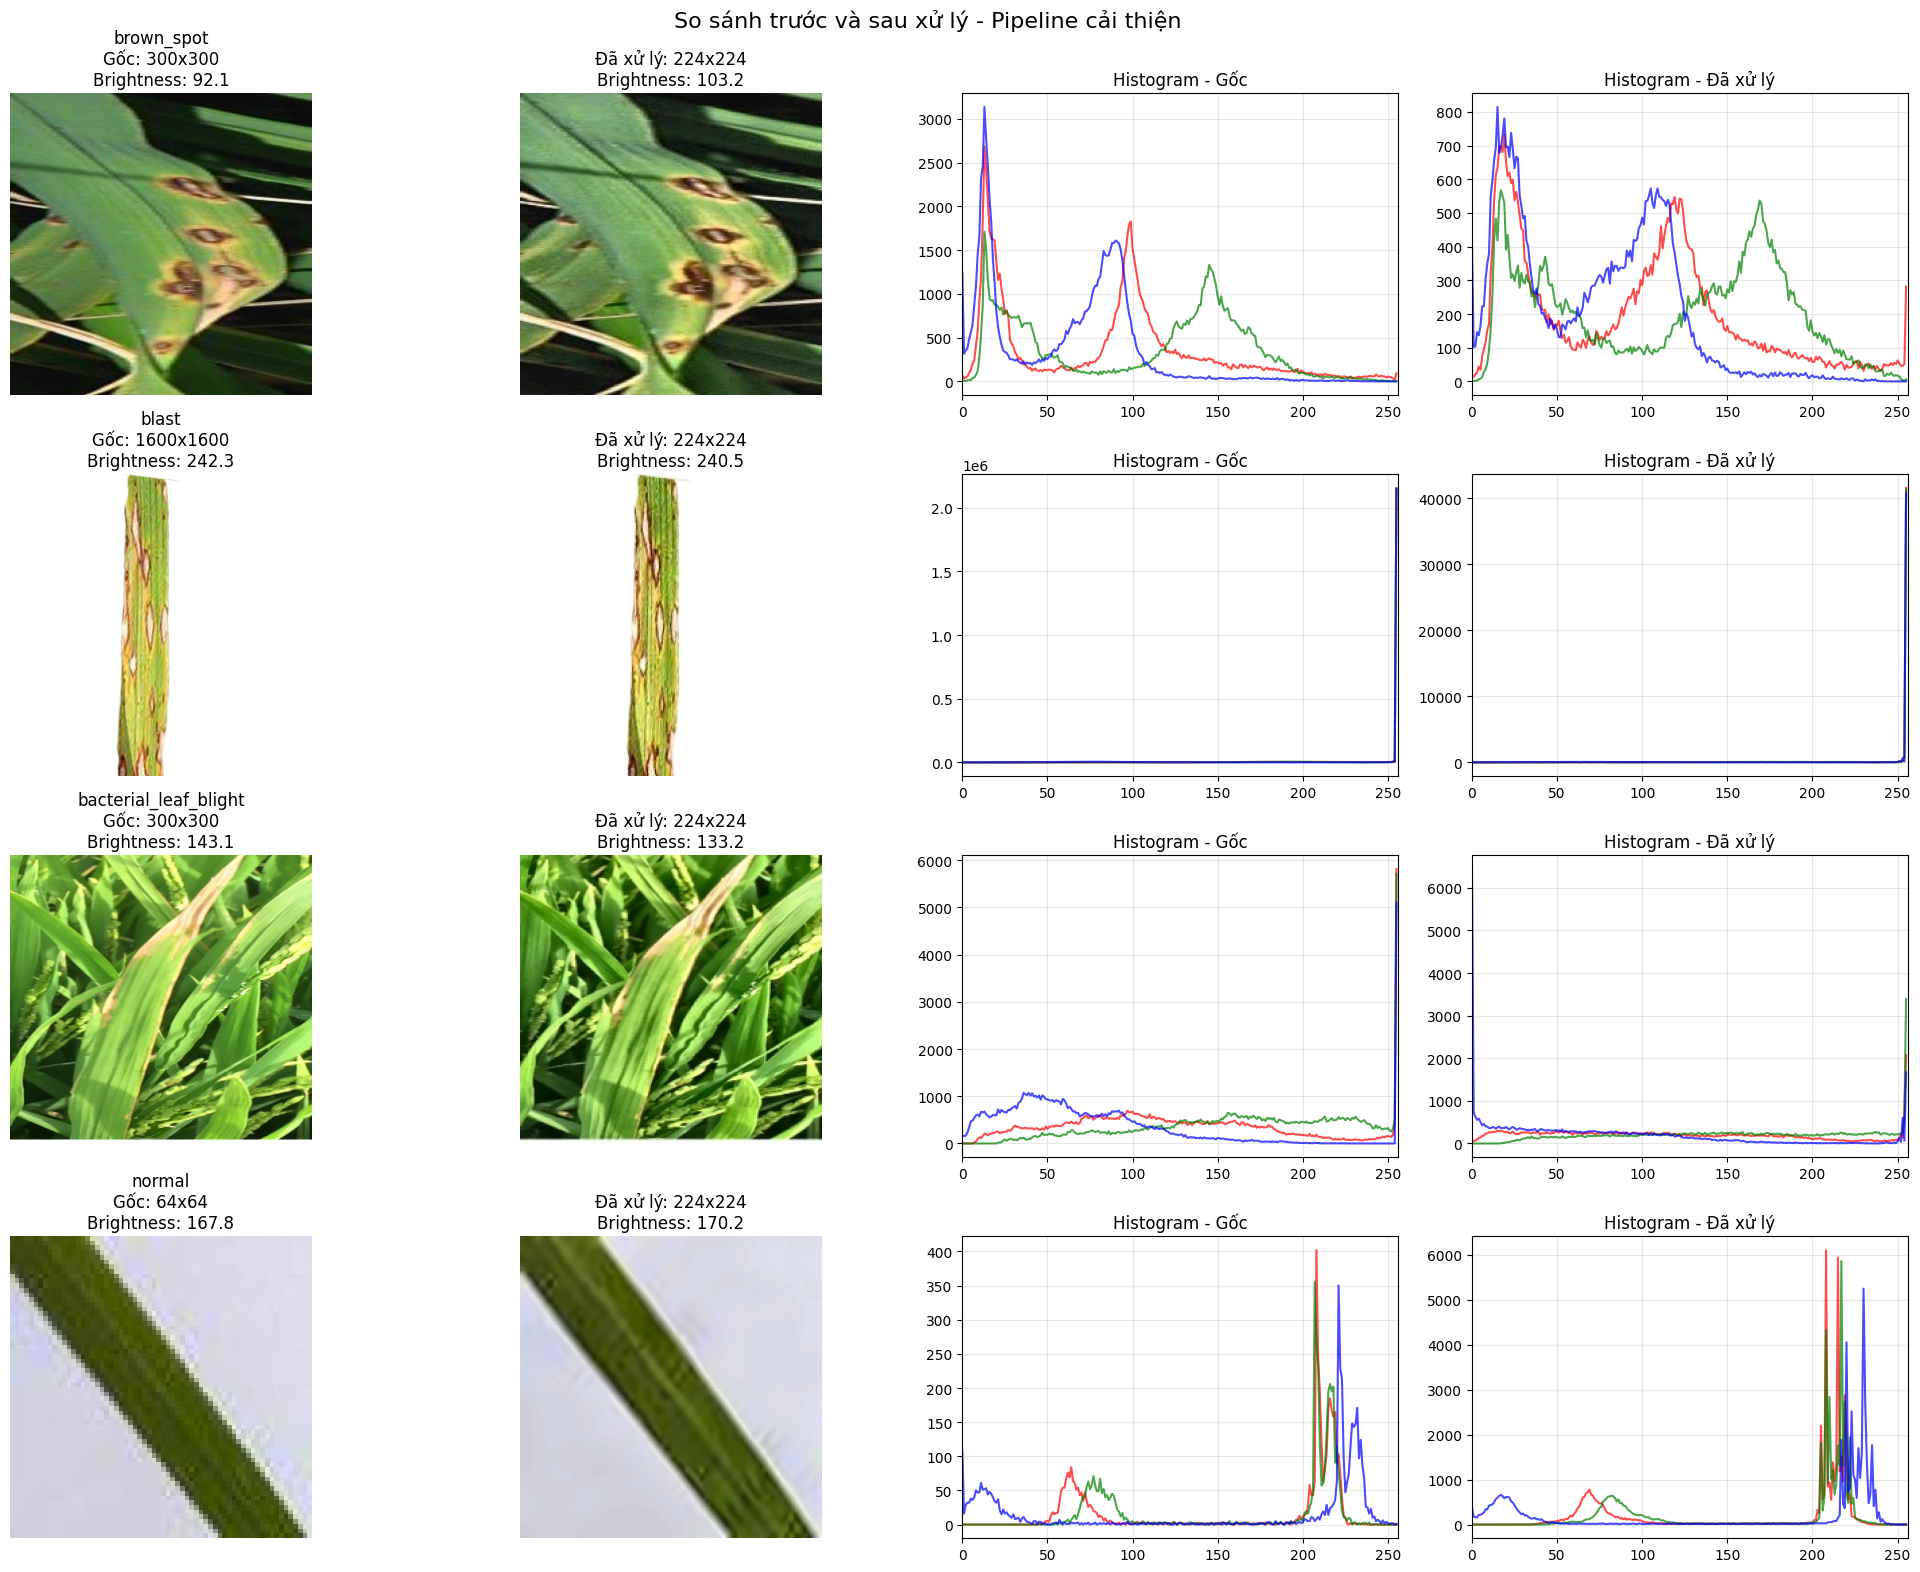

In [6]:
def visualize_improved_preprocessing():
    """Hiển thị so sánh trước và sau khi xử lý với pipeline cải thiện"""
    plt.figure(figsize=(20, 16))
    
    for i, cls in enumerate(CLASSES_CORRECTED):
        # Lấy một ảnh mẫu từ mỗi lớp
        orig_files = list((DATA_DIR / "train" / cls).glob("*"))
        if not orig_files:
            continue
            
        sample_file = orig_files[0].name
        orig_path = DATA_DIR / "train" / cls / sample_file
        proc_path = PROCESSED_DIR / "train" / cls / sample_file
        
        if orig_path.exists() and proc_path.exists():
            # Đọc ảnh gốc và ảnh đã xử lý
            img_orig = cv2.imread(str(orig_path))
            img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
            
            img_proc = cv2.imread(str(proc_path))
            img_proc = cv2.cvtColor(img_proc, cv2.COLOR_BGR2RGB)
            
            # Thông tin kích thước và độ sáng
            h_orig, w_orig = img_orig.shape[:2]
            brightness_orig = np.mean(cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY))
            brightness_proc = np.mean(cv2.cvtColor(img_proc, cv2.COLOR_RGB2GRAY))
            
            # Hiển thị ảnh gốc
            plt.subplot(len(CLASSES_CORRECTED), 4, i*4 + 1)
            plt.imshow(img_orig)
            plt.title(f"{cls}\nGốc: {w_orig}x{h_orig}\nBrightness: {brightness_orig:.1f}")
            plt.axis('off')
            
            # Hiển thị ảnh đã xử lý
            plt.subplot(len(CLASSES_CORRECTED), 4, i*4 + 2)
            plt.imshow(img_proc)
            plt.title(f"Đã xử lý: 224x224\nBrightness: {brightness_proc:.1f}")
            plt.axis('off')
            
            # Histogram gốc
            plt.subplot(len(CLASSES_CORRECTED), 4, i*4 + 3)
            for channel, color in enumerate(['r', 'g', 'b']):
                hist = cv2.calcHist([img_orig], [channel], None, [256], [0, 256])
                plt.plot(hist, color=color, alpha=0.7)
            plt.title("Histogram - Gốc")
            plt.xlim([0, 256])
            plt.grid(True, alpha=0.3)
            
            # Histogram đã xử lý
            plt.subplot(len(CLASSES_CORRECTED), 4, i*4 + 4)
            for channel, color in enumerate(['r', 'g', 'b']):
                hist = cv2.calcHist([img_proc], [channel], None, [256], [0, 256])
                plt.plot(hist, color=color, alpha=0.7)
            plt.title("Histogram - Đã xử lý")
            plt.xlim([0, 256])
            plt.grid(True, alpha=0.3)
    
    plt.suptitle("So sánh trước và sau xử lý - Pipeline cải thiện", fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Hiển thị kết quả
print("\n3. Hiển thị kết quả...")
visualize_improved_preprocessing()
